### SV calling from pairwise cigar strings - all pairs, all chroms

This notebook generates plots for SVs derived from centrolign pairwise cigar strings. 

In [1]:
# Import statements
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
## Read in input data 

# csv formatted as clade, path_to_SV_beds 
input_csv="/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/11172025_clade_chr_sv_beds.csv"

# prefix for output plots
plot_prefix="/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr8/test/plots/"

# pairwise distance file 
pairwise_dist="/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"

In [4]:
### This function reads in the SV bed files into a pandas DF for a given clade. 

def read_sv_bed_files(clade, chr, bed_folder):
    """
    Read all .bed files in a folder and add a 'clade' column to the data frame
    Each bed file has columns:
        sample1, start, end, sample2, start, end, type, diff
    """
    all_beds = []
    bed_files = [f for f in os.listdir(bed_folder) if f.endswith(".bed")]
    print(f"Found {len(bed_files)} SV bed files for clade '{clade}'")

    # Ensure folder exists
    if not os.path.isdir(bed_folder):
        raise FileNotFoundError("Folder not found for clade '{}': {}".format(clade, bed_folder))

    for filename in os.listdir(bed_folder):
        if filename.endswith(".bed"):
            bed_path = os.path.join(bed_folder, filename)
            try:
                df = pd.read_csv(
                    bed_path,
                    sep="\t",
                    header=None,
                    names=["sample1", "start1", "end1", "sample2", "start2", "end2", "type", "diff"]
                )
                df["clade"] = clade
                df["chr"] = chr
                df["source_file"] = filename  # optional, helps track origin
                df["length"] = np.where(
                    df["type"] == "I",
                    df["end2"] - df["start2"],  # insertion → use sample2 coords
                    df["end1"] - df["start1"]  # otherwise (deletion) → sample1 coords
                )
                all_beds.append(df)
            except Exception as e:
                print("Warning: Could not read {}: {}".format(bed_path, e))

    if all_beds:
        return pd.concat(all_beds, ignore_index=True)
    else:
        print("Warning: No .bed files found in {} for clade '{}'".format(bed_folder, clade))
        return pd.DataFrame(columns=["sample1", "start1", "end1", "sample2", "start2", "end2", "type", "diff", "clade", "source_file","chr"])

In [5]:
### For all clades in provided input csv, read SVs into dataframe and merge 

clade_info = pd.read_csv(input_csv)
if not {"clade", "chr","path_to_SV_beds"}.issubset(clade_info.columns):
    raise ValueError("Input CSV must contain columns: 'clade' and 'chr' and 'path_to_SV_beds'")

#clade_info_subset= clade_info.head(3)

all_data = []

for _, row in clade_info.iterrows():
    clade = str(row["clade"])
    chr = str(row["chr"])
    bed_folder = str(row["path_to_SV_beds"])
    df = read_sv_bed_files(clade, chr, bed_folder)
    if not df.empty:
        all_data.append(df)

if all_data:
    merged_df = pd.concat(all_data, ignore_index=True)

    #print("=== Head of merged DataFrame ===")
    #(merged_df.head(), "\n")

    # Print count of rows per clade
    print("=== Record count per clade ===")
    print(merged_df["clade"].value_counts())

Found 10440 SV bed files for clade 'chr5_subgroup0'
Found 18528 SV bed files for clade 'chr5_subgroup1'
Found 17205 SV bed files for clade 'chr12_subgroup0'
Found 17391 SV bed files for clade 'chr12_subgroup1'
Found 18336 SV bed files for clade 'chr8_subgroup0'
Found 12403 SV bed files for clade 'chr8_subgroup1'
Found 9591 SV bed files for clade 'chr17'
Found 6786 SV bed files for clade 'chr18'
Found 18721 SV bed files for clade 'chr6'
Found 7750 SV bed files for clade 'chr4'
Found 9453 SV bed files for clade 'chr3'
Found 19110 SV bed files for clade 'chr7_subgroup0'
Found 5050 SV bed files for clade 'chr7_subgroup1'
Found 16110 SV bed files for clade 'chr22_subgroup0'
Found 17391 SV bed files for clade 'chr22_subgroup1'
Found 11026 SV bed files for clade 'chr20_subgroupB'
Found 16110 SV bed files for clade 'chr20_subgroupD'
Found 12246 SV bed files for clade 'chr1_subgroupB'
Found 988 SV bed files for clade 'chrY'
Found 22366 SV bed files for clade 'chr19_subgroup0'
Found 5050 SV bed 

In [7]:
print(merged_df.columns)

Index(['sample1', 'start1', 'end1', 'sample2', 'start2', 'end2', 'type',
       'diff', 'clade', 'chr', 'source_file', 'length'],
      dtype='object')


In [8]:
import pandas as pd
import numpy as np
import glob
import os

# Directory containing CSV files
pairwise_dist_dir = pairwise_dist  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None, names=['sample1', 'sample2', 'pairwise_dist'])
    df["chr"] = chr_val

    all_dfs.append(df)

# Combine into one dataframe
dist_df = pd.concat(all_dfs, ignore_index=True)

# Sort sample pairs so ordering doesn't matter
df_dist_sorted = dist_df.copy()
df_dist_sorted[['sample1', 'sample2']] = np.sort(df_dist_sorted[['sample1', 'sample2']], axis=1)

df_sv_sorted = merged_df.copy()
df_sv_sorted[['sample1', 'sample2']] = np.sort(df_sv_sorted[['sample1', 'sample2']], axis=1)

# Merge on sample1, sample2, AND chr
df_sv_sorted = df_sv_sorted.merge(df_dist_sorted, on=['sample1', 'sample2', 'chr'], how='left')

df_sv_sorted.head()


sample1  start1   end1    sample2  start2  end2 type  diff           clade  \
0  HG002.1     963  11456  HG03742.2     963   964    D  -1.0  chr5_subgroup0   
1  HG002.1   13009  16731  HG03742.2    2516  2517    D  -1.0  chr5_subgroup0   
2  HG002.1   16882  16883  HG03742.2    2667  3006    I  -1.0  chr5_subgroup0   
3  HG002.1   16924  17264  HG03742.2    3048  3049    D  -1.0  chr5_subgroup0   
4  HG002.1   20842  23243  HG03742.2    6626  6627    D   0.0  chr5_subgroup0   

    chr            source_file  length pairwise_dist  
0  chr5  HG002.1_HG03742.2.bed   10493      0.917844  
1  chr5  HG002.1_HG03742.2.bed    3722      0.917844  
2  chr5  HG002.1_HG03742.2.bed     339      0.917844  
3  chr5  HG002.1_HG03742.2.bed     340      0.917844  
4  chr5  HG002.1_HG03742.2.bed    2401      0.917844

In [9]:
# Create a sample_pair identifier
df_sv_sorted["sample_pair"] = df_sv_sorted["sample1"] + "_" + df_sv_sorted["sample2"]

/data/tmp/ipykernel_2377993/3019868906.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/3019868906.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/3019868906.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


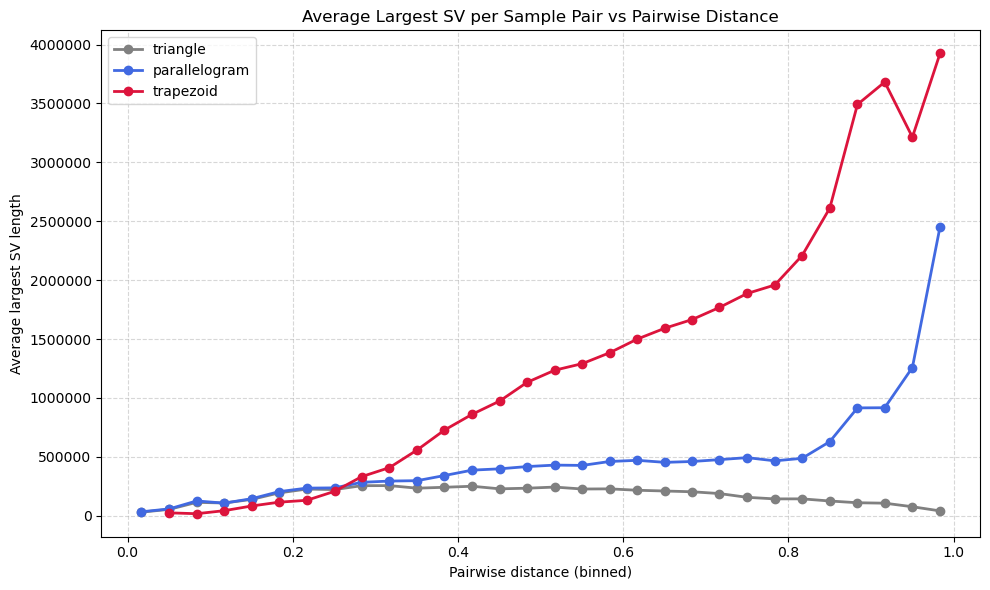

In [11]:
### All chromosomes combined 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Ensure sample_pair is defined
df_sv_sorted["sample_pair"] = df_sv_sorted["sample1"] + "_" + df_sv_sorted["sample2"]


conditions = {
    "triangle":  (df_sv_sorted["diff"] == -1),
    "parallelogram": (df_sv_sorted["diff"] < 0.1),
    "trapezoid": (df_sv_sorted["diff"] > 0.1)
}

colors = {
    "triangle": "gray",
    "parallelogram": "royalblue",
    "trapezoid": "crimson"
}


# -------------------------------------------------------
# 1. Define bins over pairwise distance
# -------------------------------------------------------
n_bins = 30
df_sv_sorted['pairwise_dist'] = df_sv_sorted['pairwise_dist'].astype(float)
bins = pd.cut(df_sv_sorted["pairwise_dist"], bins=n_bins)


# -------------------------------------------------------
# 2. Function: largest SV per sample pair
# -------------------------------------------------------
def get_largest_sv(subset):
    largest = (
        subset.sort_values("length", ascending=False)
              .groupby("sample_pair", as_index=False)
              .first()   # row with maximum 'length'
    )
    return largest


# -------------------------------------------------------
# 3. Compute mean largest-SV per bin per condition
# -------------------------------------------------------
plot_df = []

for label, mask in conditions.items():
    subset = df_sv_sorted[mask].copy()

    # collapse to largest SV per sample_pair
    largest = get_largest_sv(subset)

    # bin distances for these pairs
    largest["dist_bin"] = pd.cut(largest["pairwise_dist"], bins=bins.cat.categories)

    # compute mean length per bin
    stats = (
        largest.groupby("dist_bin")["length"]
               .mean()
               .reset_index(name="mean_length")
    )
    stats["condition"] = label
    plot_df.append(stats)

plot_df = pd.concat(plot_df, ignore_index=True)


# -------------------------------------------------------
# 4. Plot
# -------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

for label in conditions.keys():
    df_c = plot_df[plot_df["condition"] == label].copy()

    # x-axis = midpoint of each distance bin
    df_c["midpoint"] = df_c["dist_bin"].apply(lambda x: x.mid)

    ax.plot(
        df_c["midpoint"],
        df_c["mean_length"],
        marker="o",
        color=colors[label],
        linewidth=2,
        label=label
    )

ax.set_xlabel("Pairwise distance (binned)")
ax.set_ylabel("Average largest SV length")
ax.set_title("Average Largest SV per Sample Pair vs Pairwise Distance")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

yfmt = ScalarFormatter(useOffset=False)
yfmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(yfmt)
plt.tight_layout()
plt.show()

/data/tmp/ipykernel_2377993/3947507109.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/3947507109.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/3947507109.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/3947507109.py:45: FutureWarning: The def

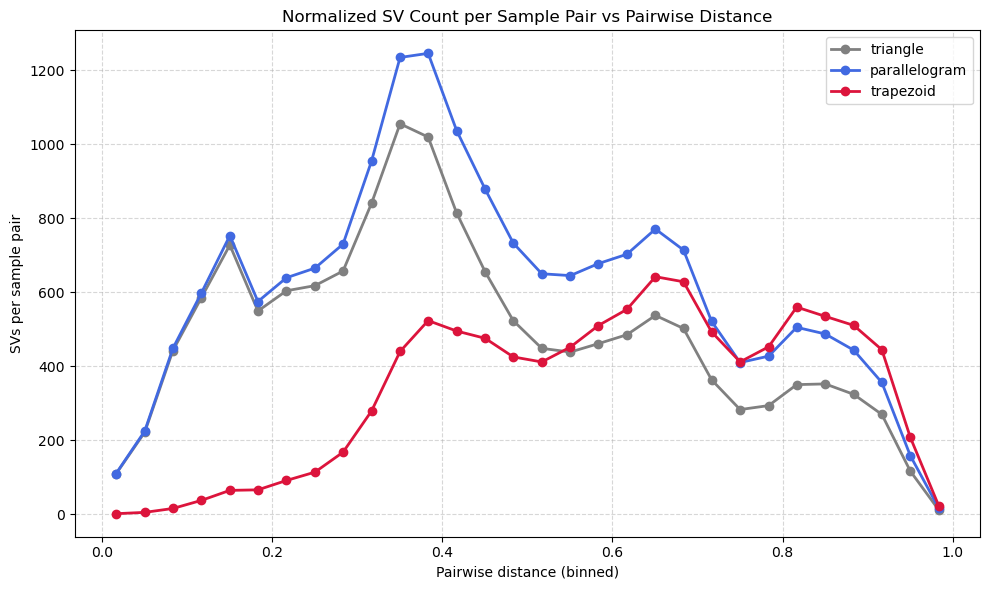

In [12]:
# All chromosomes combined 
from matplotlib.ticker import ScalarFormatter

conditions = {
    "triangle":  (df_sv_sorted["diff"] == -1),
    "parallelogram": (df_sv_sorted["diff"] < 0.1),
    "trapezoid": (df_sv_sorted["diff"] > 0.1)
}

colors = {
    "triangle": "gray",
    "parallelogram": "royalblue",
    "trapezoid": "crimson"
}

# -------------------------------------------------------
# 1. Define global distance bins
# -------------------------------------------------------
n_bins = 30
df_sv_sorted["dist_bin"] = pd.cut(df_sv_sorted["pairwise_dist"], bins=n_bins)

# -------------------------------------------------------
# 2. Count how many sample pairs occur in each bin
# -------------------------------------------------------
# One row per sample-pair for correct weighting
pairs = df_sv_sorted.groupby("sample_pair", as_index=False)["pairwise_dist"].first()
pairs["dist_bin"] = pd.cut(pairs["pairwise_dist"], bins=df_sv_sorted["dist_bin"].cat.categories)

sample_pair_counts = (
    pairs.groupby("dist_bin")
         .size()
         .reset_index(name="num_pairs_in_bin")
)

# -------------------------------------------------------
# 3. Count SVs per bin per condition
# -------------------------------------------------------
plot_df = []

for label, mask in conditions.items():

    subset = df_sv_sorted[mask]

    sv_counts = (
        subset.groupby("dist_bin")
              .size()
              .reset_index(name="sv_count")
    )

    # merge in the number of sample pairs in that bin
    merged = sv_counts.merge(sample_pair_counts, on="dist_bin", how="left")

    # Normalize:
    merged["svs_per_pair"] = merged["sv_count"] / merged["num_pairs_in_bin"]

    merged["condition"] = label
    plot_df.append(merged)

plot_df = pd.concat(plot_df, ignore_index=True)

# -------------------------------------------------------
# 4. Plot normalized SV counts
# -------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

for label in conditions.keys():
    df_c = plot_df[plot_df["condition"] == label].copy()

    # Convert bins to midpoints for plotting
    df_c["midpoint"] = df_c["dist_bin"].apply(lambda x: x.mid)

    ax.plot(
        df_c["midpoint"],
        df_c["svs_per_pair"],
        marker="o",
        color=colors[label],
        linewidth=2,
        label=label
    )

ax.set_xlabel("Pairwise distance (binned)")
ax.set_ylabel("SVs per sample pair")
ax.set_title("Normalized SV Count per Sample Pair vs Pairwise Distance")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()


yfmt = ScalarFormatter(useOffset=False)
yfmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(yfmt)
plt.tight_layout()
plt.show()

Processing chromosome: chr1


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

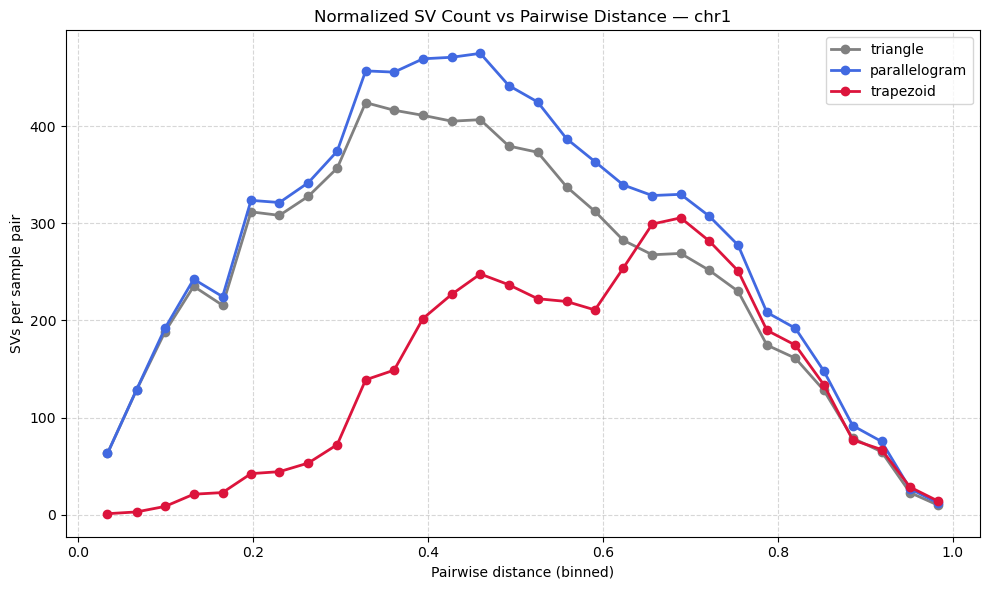

Processing chromosome: chr10


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

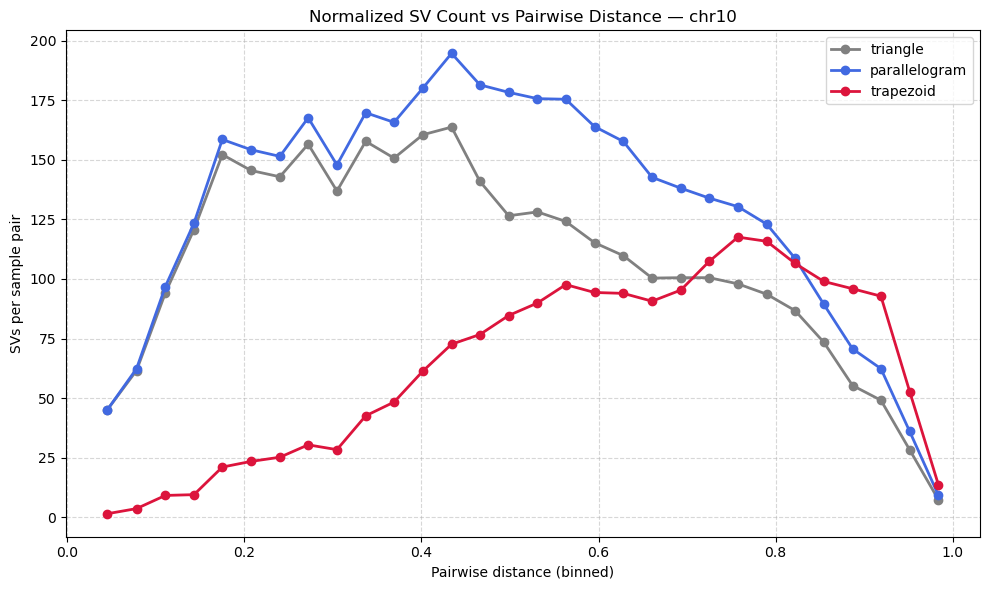

Processing chromosome: chr11


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

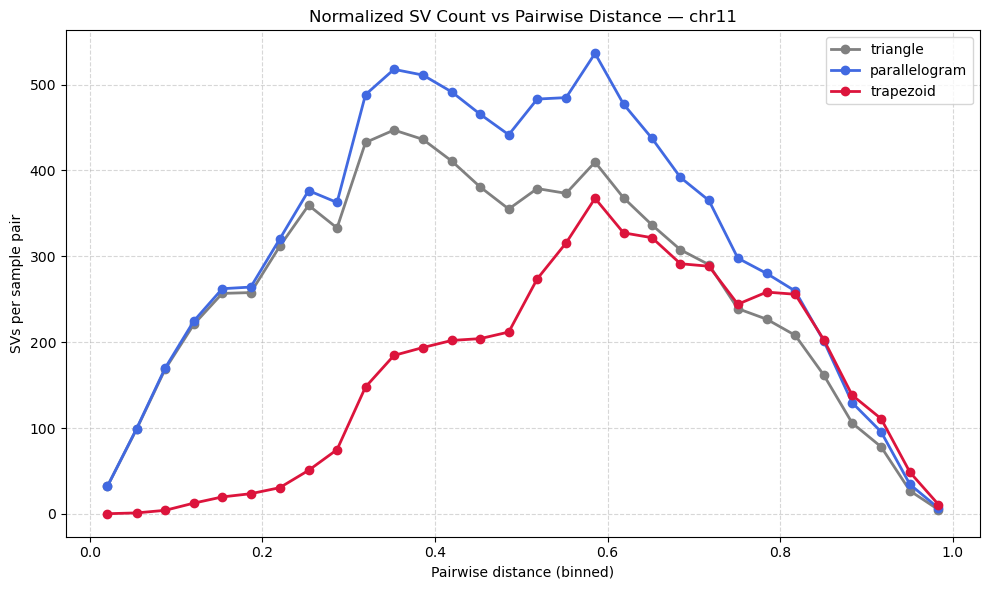

Processing chromosome: chr12


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

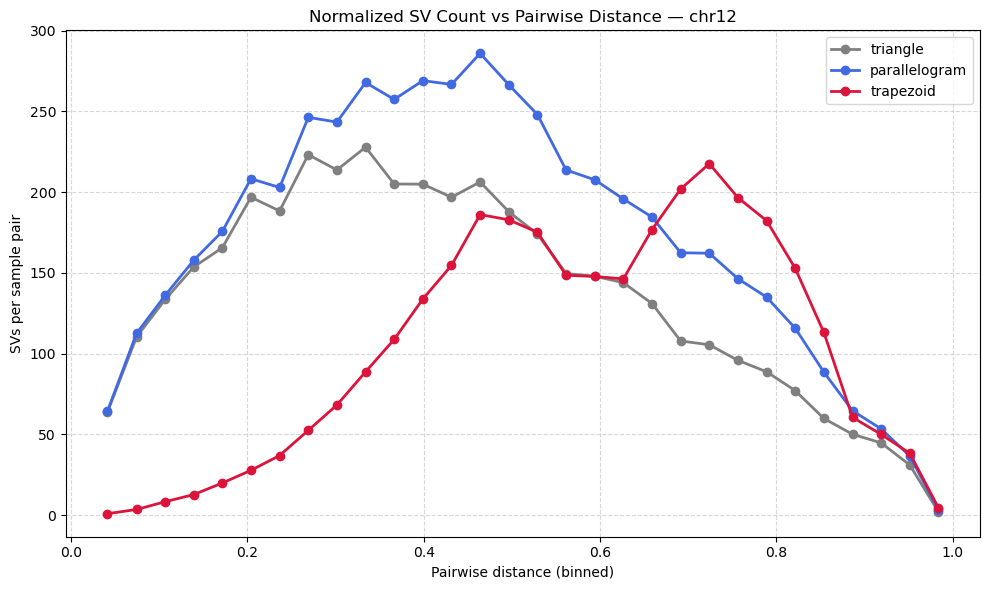

Processing chromosome: chr17


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

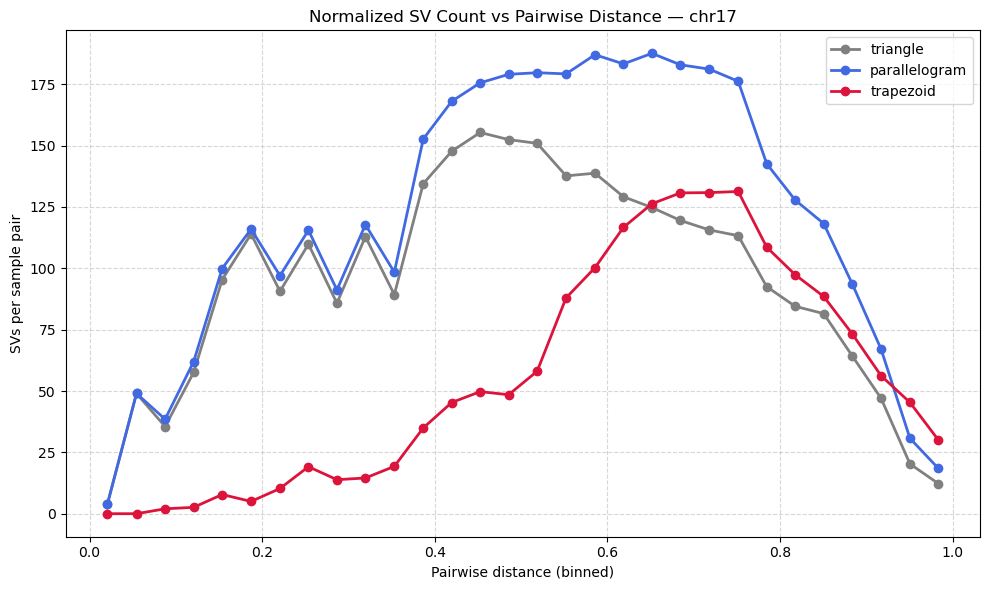

Processing chromosome: chr18


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

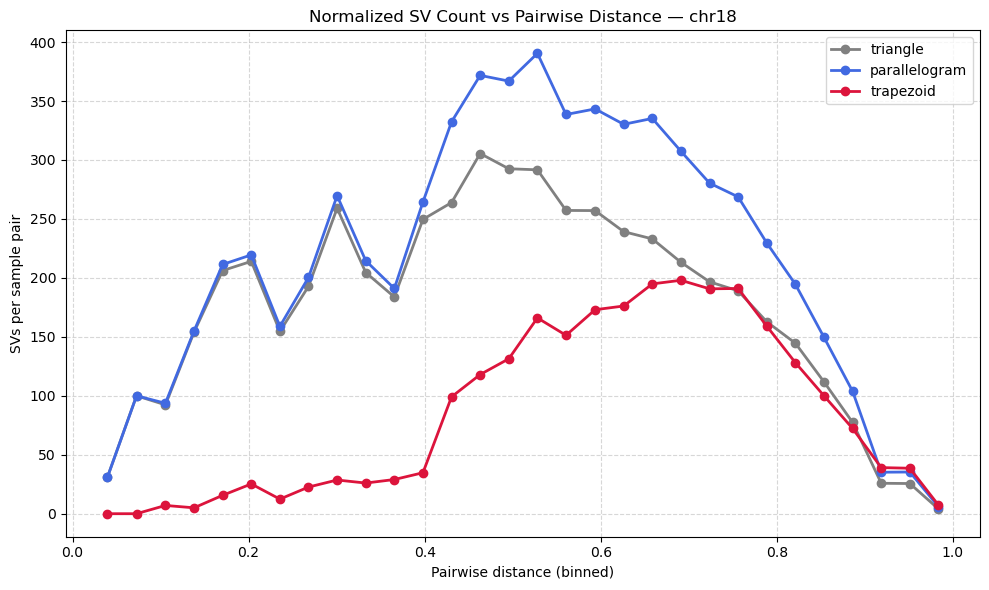

Processing chromosome: chr19


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

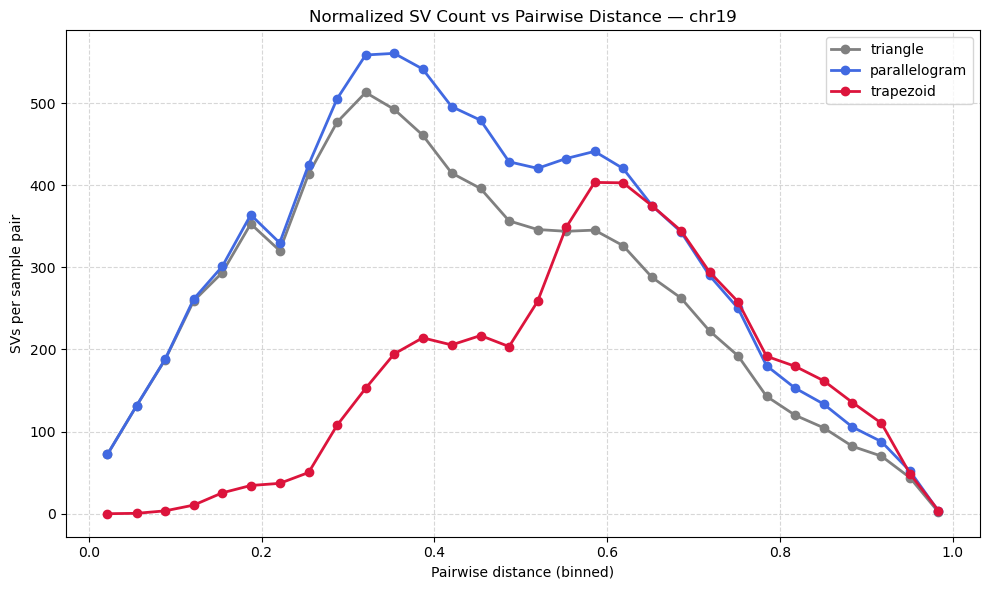

Processing chromosome: chr20


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

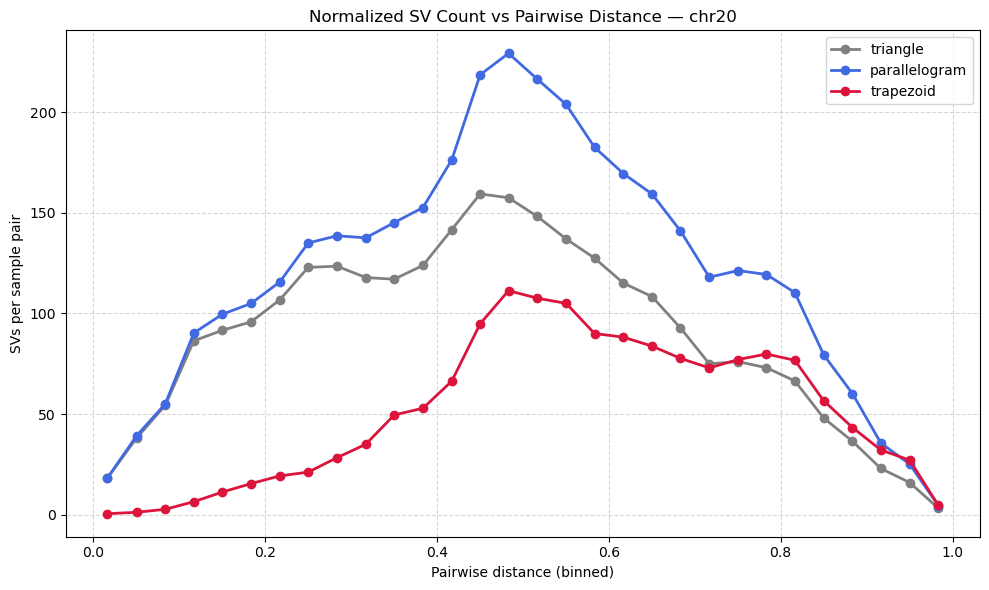

Processing chromosome: chr21


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

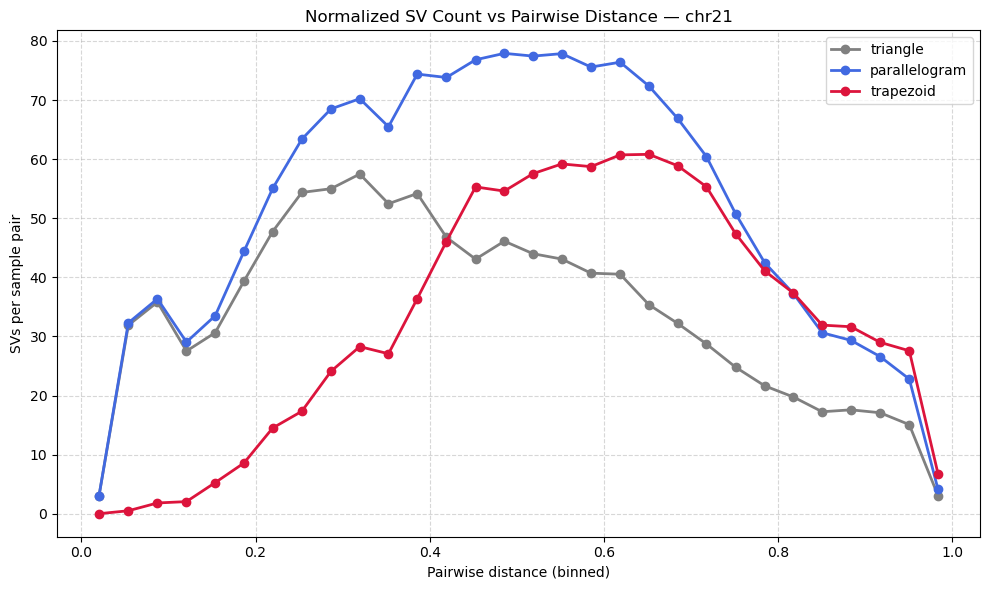

Processing chromosome: chr22


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

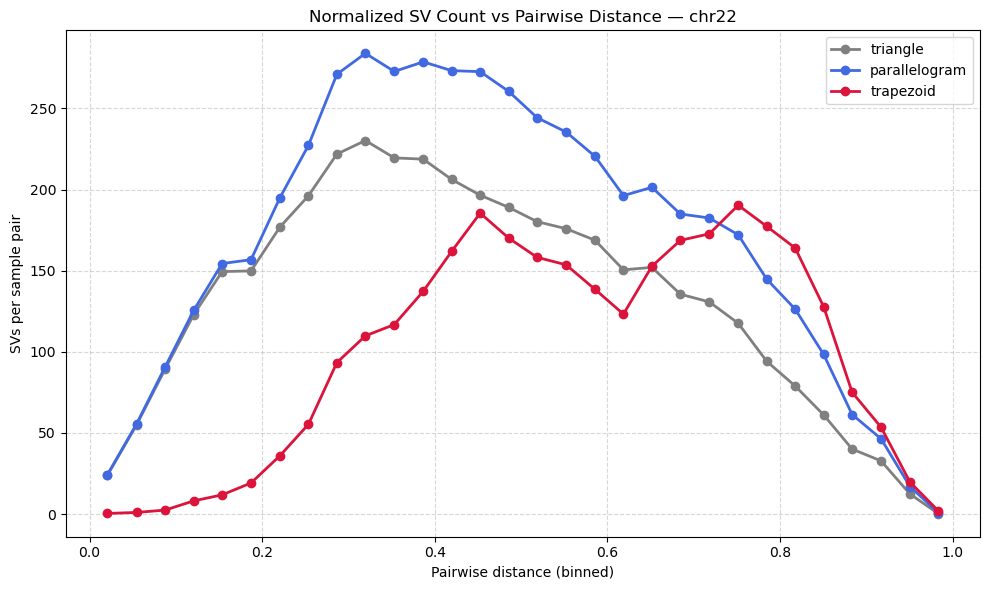

Processing chromosome: chr3


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

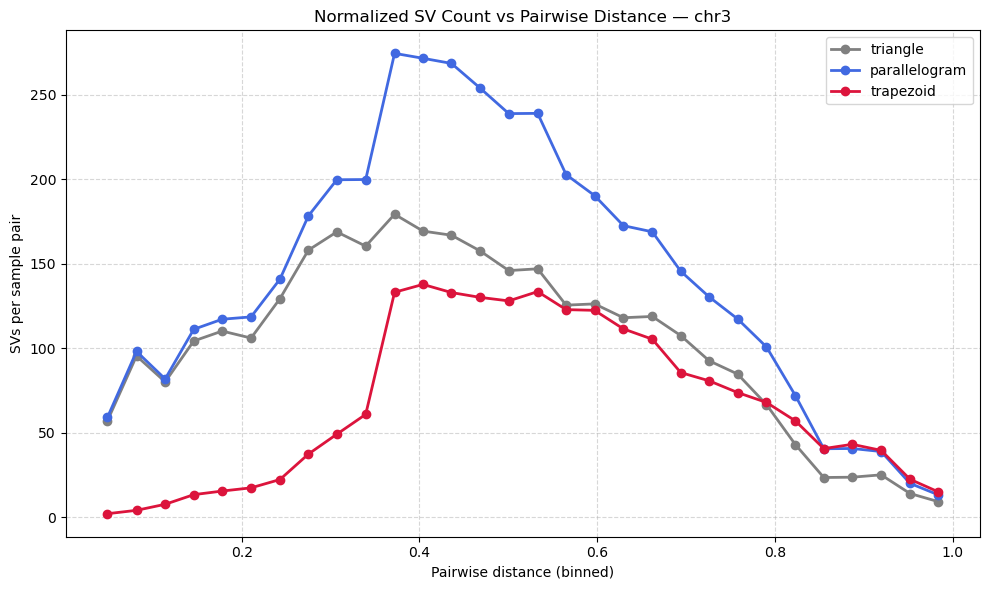

Processing chromosome: chr4


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

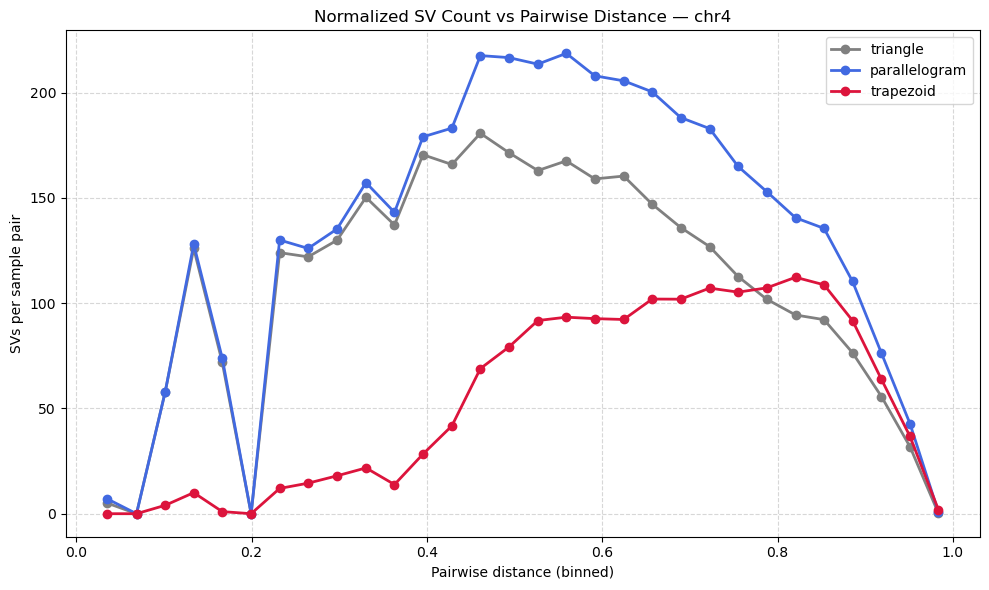

Processing chromosome: chr5


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

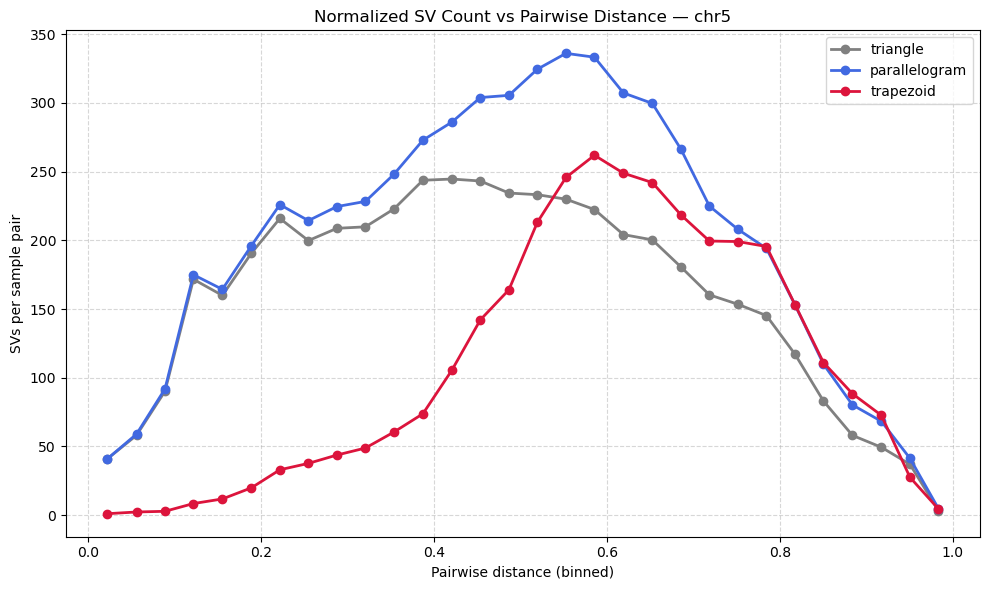

Processing chromosome: chr6


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

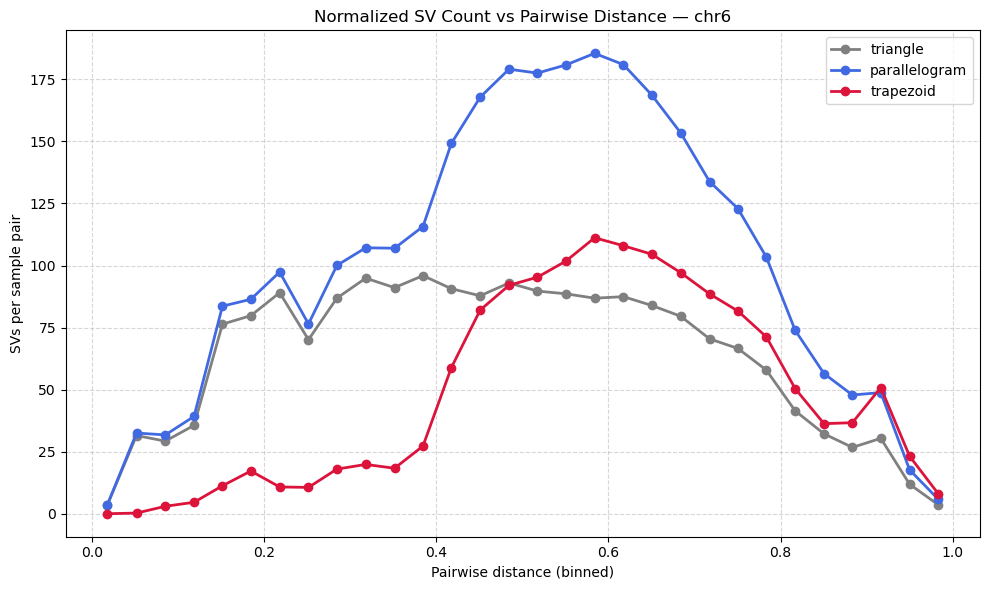

Processing chromosome: chr7


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

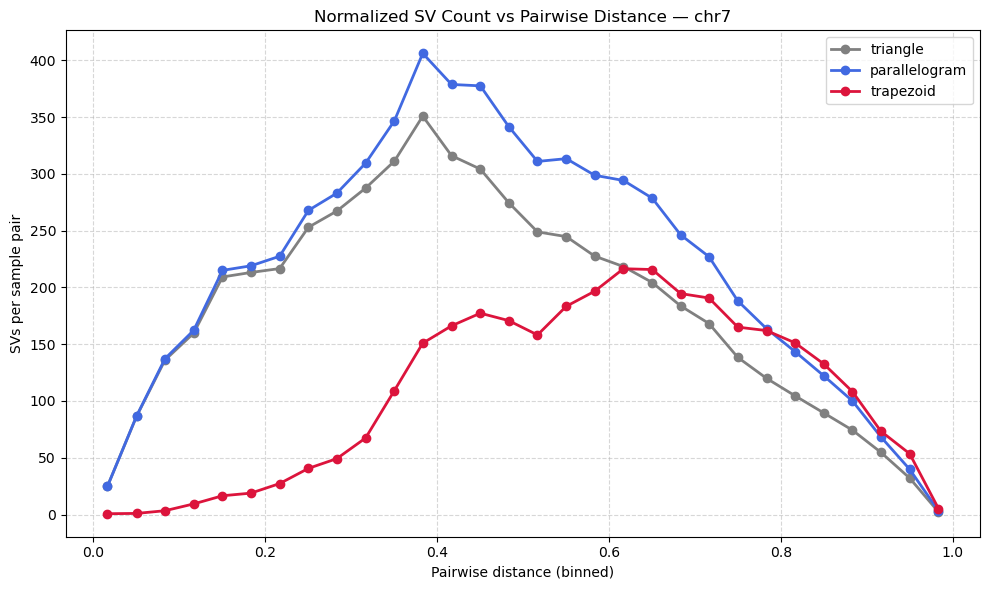

Processing chromosome: chr8


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

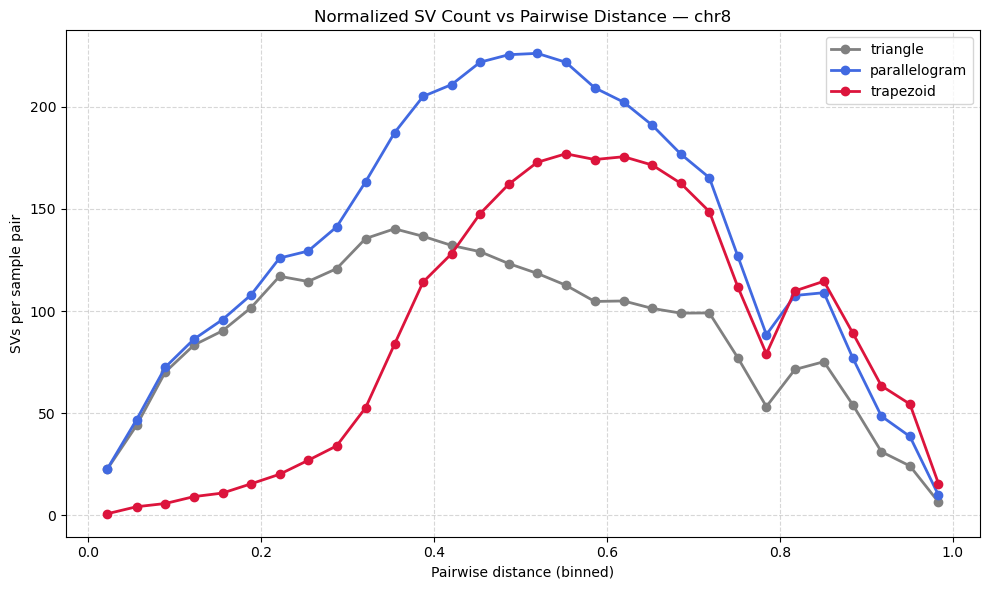

Processing chromosome: chr9


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

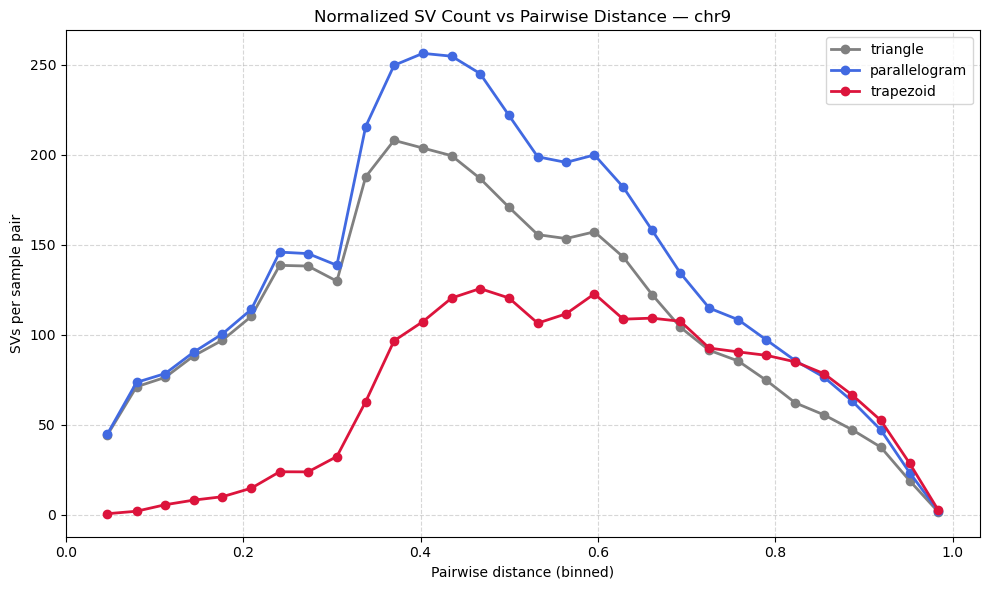

Processing chromosome: chrY


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

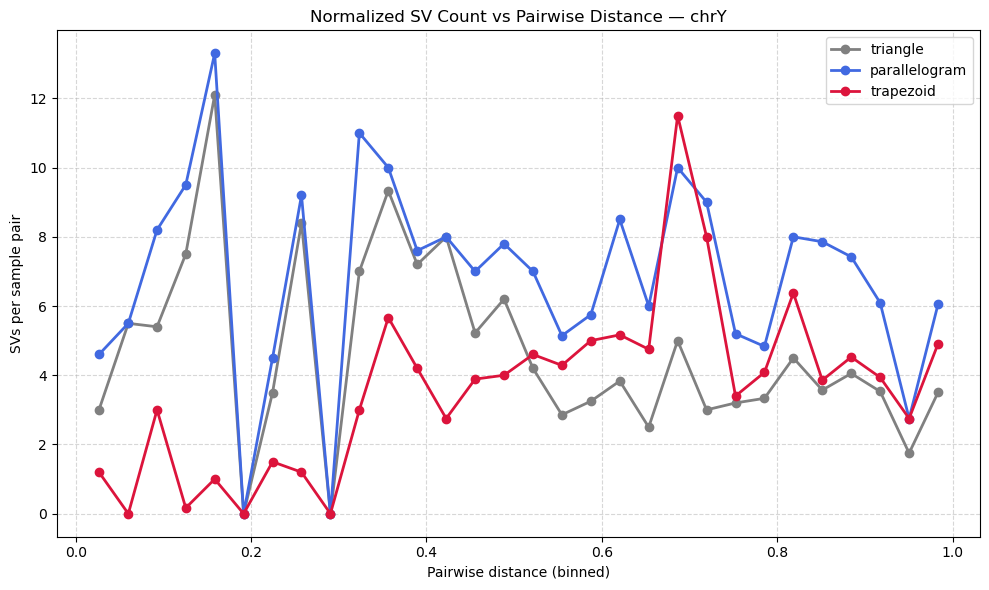

In [13]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
import numpy as np

colors = {
    "triangle": "gray",
    "parallelogram": "royalblue",
    "trapezoid": "crimson"
}

# -----------------------------------------
# Loop over chromosomes
# -----------------------------------------
for chr_val in sorted(df_sv_sorted["chr"].unique()):

    print(f"Processing chromosome: {chr_val}")

    df_chr = df_sv_sorted[df_sv_sorted["chr"] == chr_val].copy()

    # -----------------------------------------
    # 1. Clean distance column and create bins
    # -----------------------------------------
    n_bins = 30

    df_chr["pairwise_dist"] = pd.to_numeric(df_chr["pairwise_dist"], errors="coerce")
    df_chr = df_chr.dropna(subset=["pairwise_dist"])

    df_chr["dist_bin"] = pd.cut(df_chr["pairwise_dist"], bins=n_bins)

    # -----------------------------------------
    # Condition masks must be computed on df_chr
    # -----------------------------------------
    conditions = {
        "triangle": (df_chr["diff"] == -1),
        "parallelogram": (df_chr["diff"] < 0.1),
        "trapezoid": (df_chr["diff"] > 0.1)
    }

    # -----------------------------------------
    # 2. Count unique sample pairs for weighting
    # -----------------------------------------
    pairs = df_chr.groupby("sample_pair", as_index=False)["pairwise_dist"].first()
    pairs["pairwise_dist"] = pd.to_numeric(pairs["pairwise_dist"], errors="coerce")
    pairs = pairs.dropna(subset=["pairwise_dist"])

    pairs["dist_bin"] = pd.cut(pairs["pairwise_dist"], bins=df_chr["dist_bin"].cat.categories)

    sample_pair_counts = (
        pairs.groupby("dist_bin")
             .size()
             .reset_index(name="num_pairs_in_bin")
    )

    # -----------------------------------------
    # 3. Count SVs per bin per condition
    # -----------------------------------------
    plot_df = []

    for label, mask in conditions.items():

        subset = df_chr[mask]

        sv_counts = (
            subset.groupby("dist_bin")
                  .size()
                  .reset_index(name="sv_count")
        )

        merged = sv_counts.merge(sample_pair_counts, on="dist_bin", how="left")
        merged["num_pairs_in_bin"] = merged["num_pairs_in_bin"].fillna(0)

        merged["svs_per_pair"] = np.where(
            merged["num_pairs_in_bin"] > 0,
            merged["sv_count"] / merged["num_pairs_in_bin"],
            0
        )

        merged["condition"] = label
        plot_df.append(merged)

    plot_df = pd.concat(plot_df, ignore_index=True)

    # -----------------------------------------
    # 4. Plot — one figure per chromosome
    # -----------------------------------------
    fig, ax = plt.subplots(figsize=(10, 6))

    for label in conditions.keys():
        df_c = plot_df[plot_df["condition"] == label].copy()
        if df_c.empty:
            continue

        df_c["midpoint"] = df_c["dist_bin"].apply(lambda x: x.mid)

        ax.plot(
            df_c["midpoint"],
            df_c["svs_per_pair"],
            marker="o",
            color=colors[label],
            linewidth=2,
            label=label
        )

    ax.set_xlabel("Pairwise distance (binned)")
    ax.set_ylabel("SVs per sample pair")
    ax.set_title(f"Normalized SV Count vs Pairwise Distance — {chr_val}")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

    plt.tight_layout()
    plt.show()


Processing chromosome: chr1


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


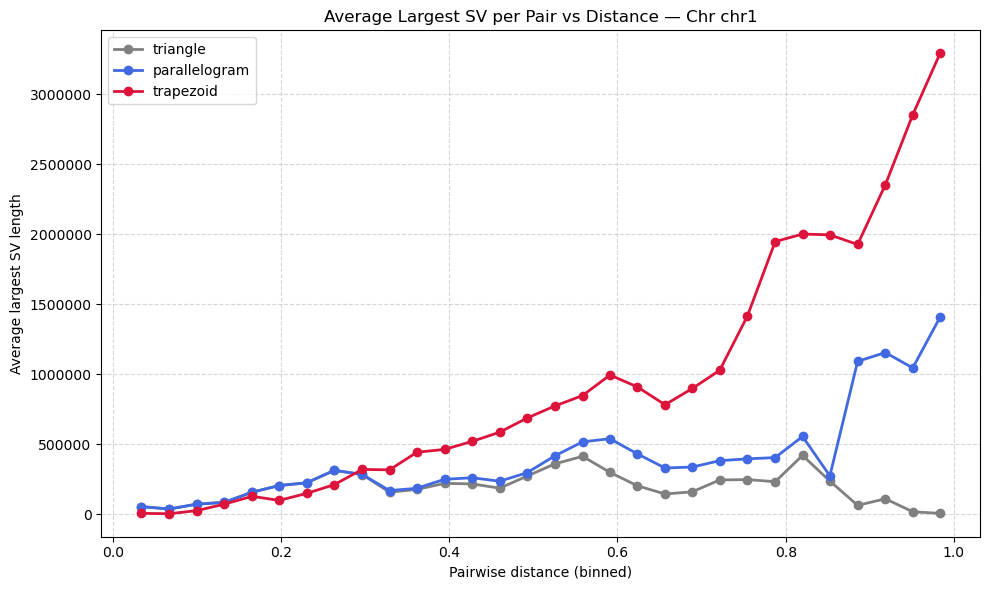

Processing chromosome: chr10


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


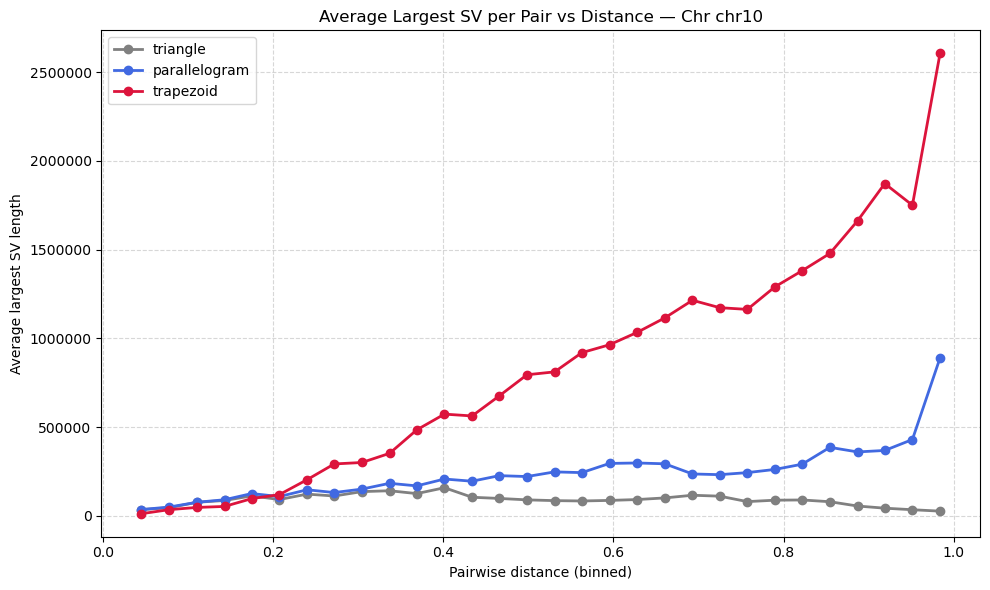

Processing chromosome: chr11


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


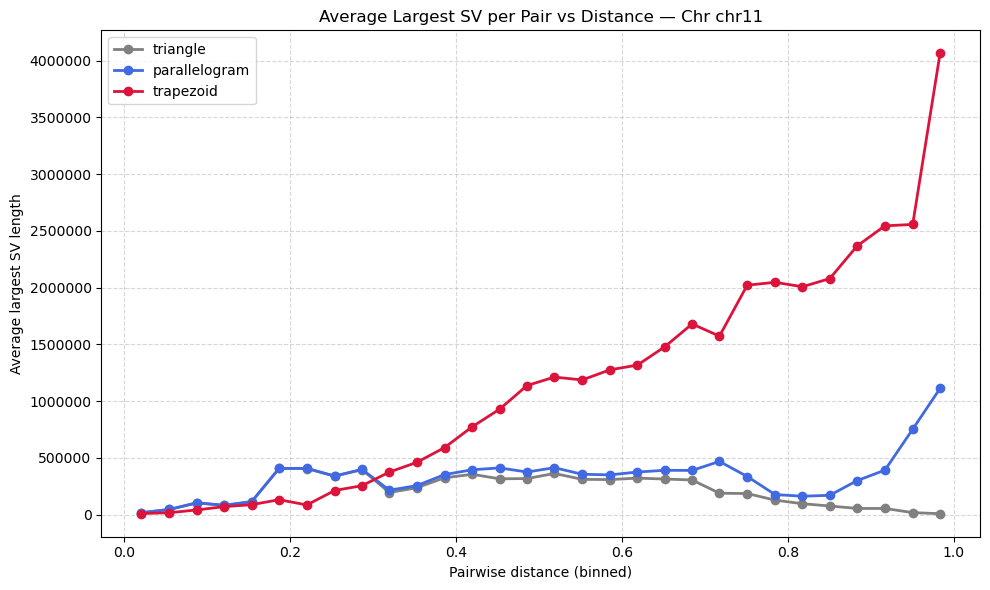

Processing chromosome: chr12


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


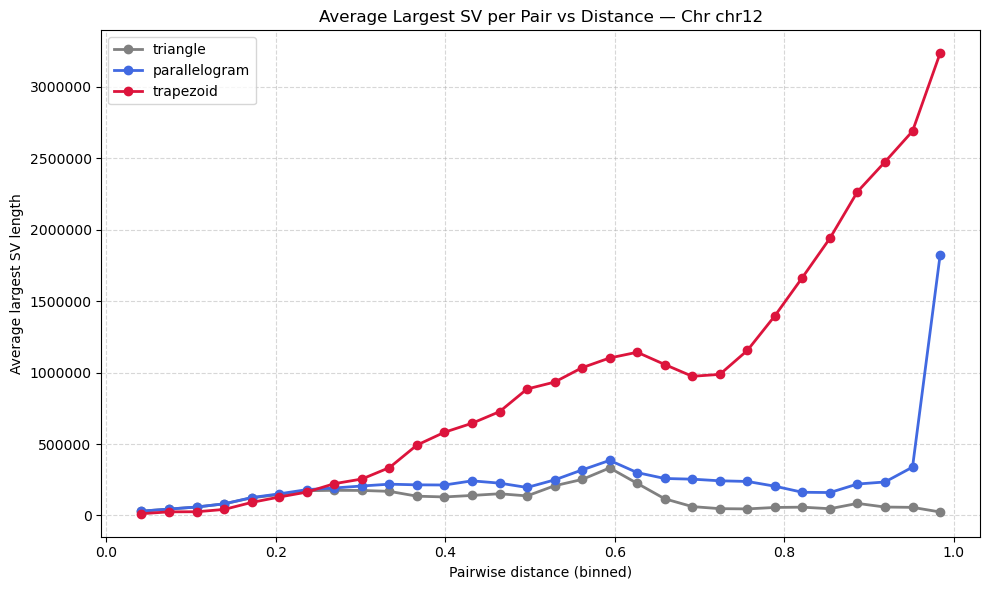

Processing chromosome: chr17


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


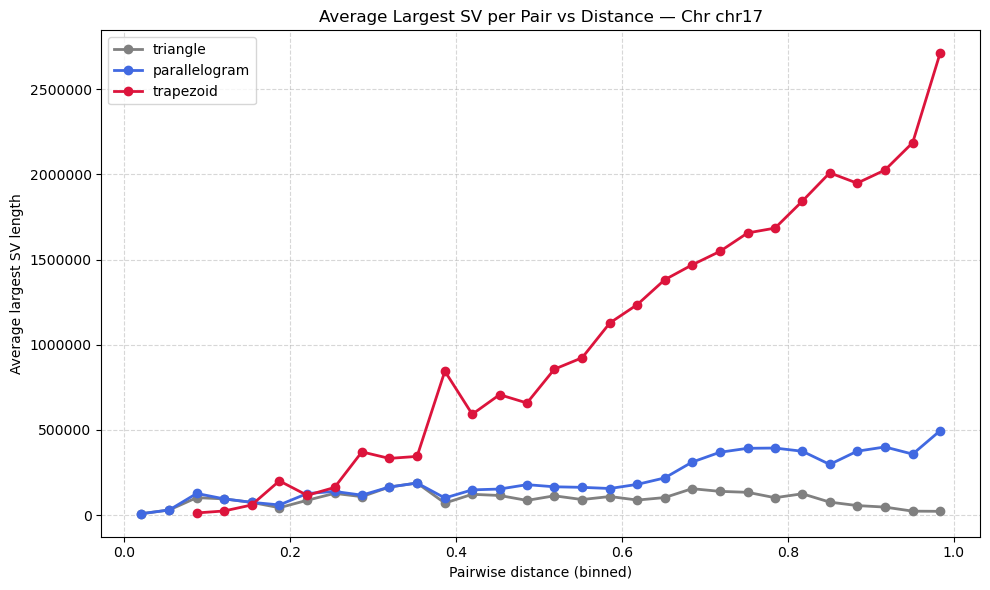

Processing chromosome: chr18


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


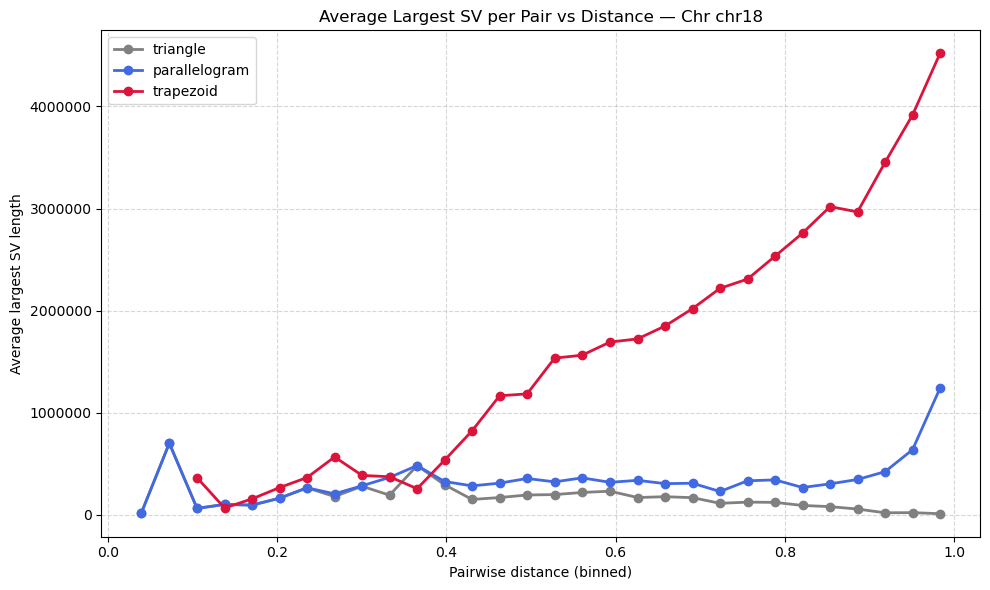

Processing chromosome: chr19


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


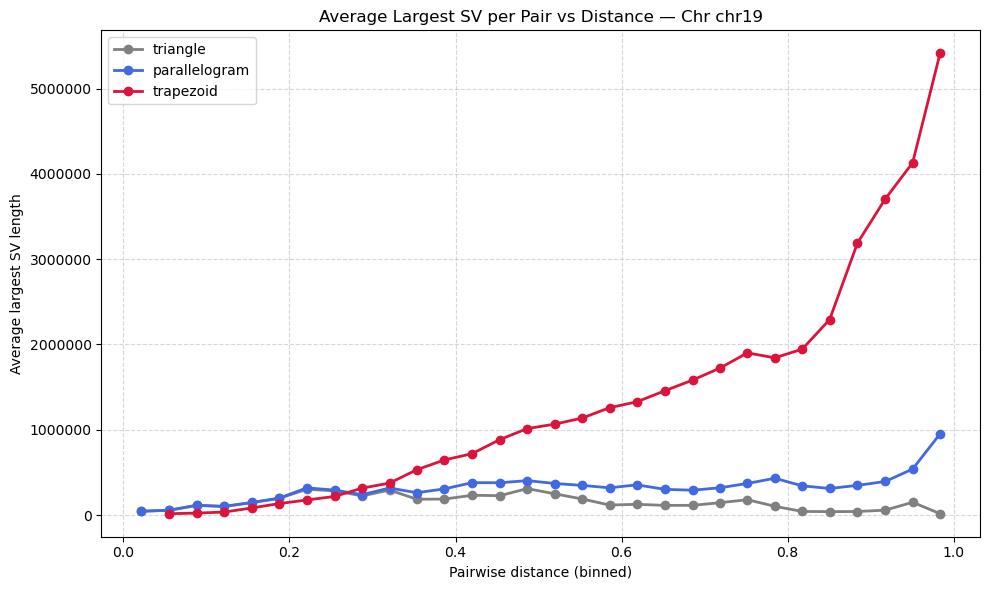

Processing chromosome: chr20


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


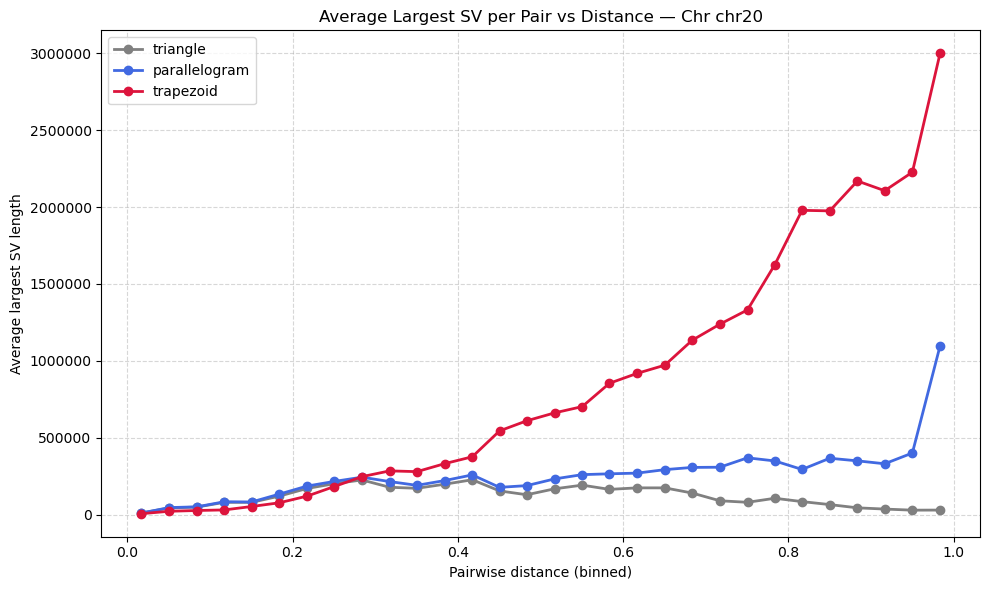

Processing chromosome: chr21


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


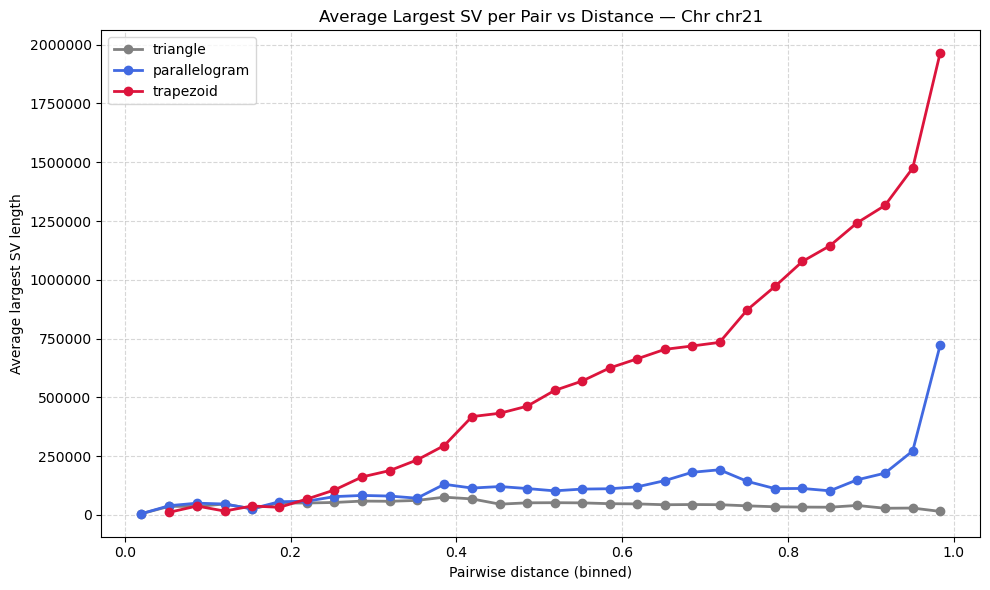

Processing chromosome: chr22


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


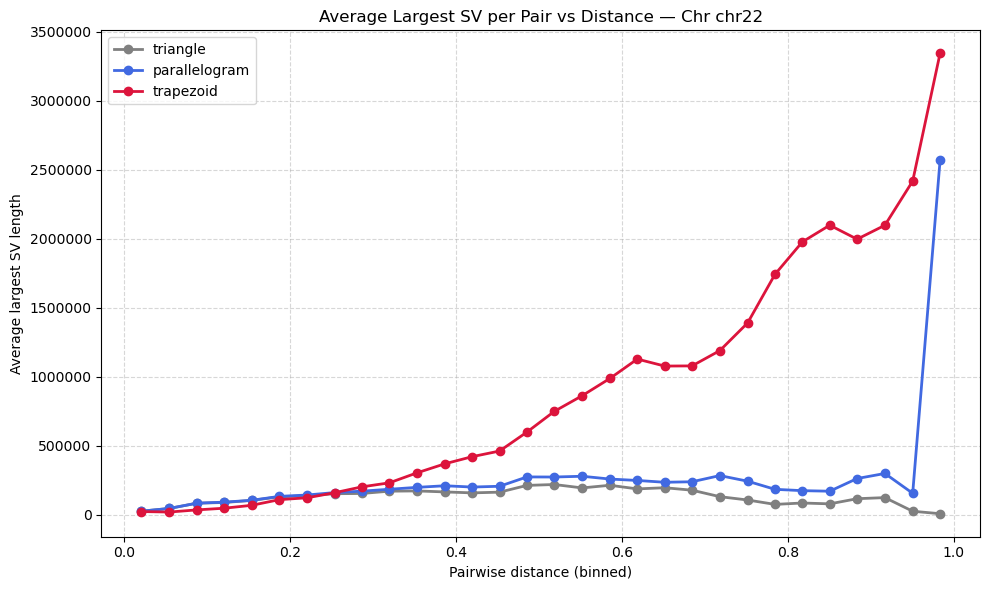

Processing chromosome: chr3


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


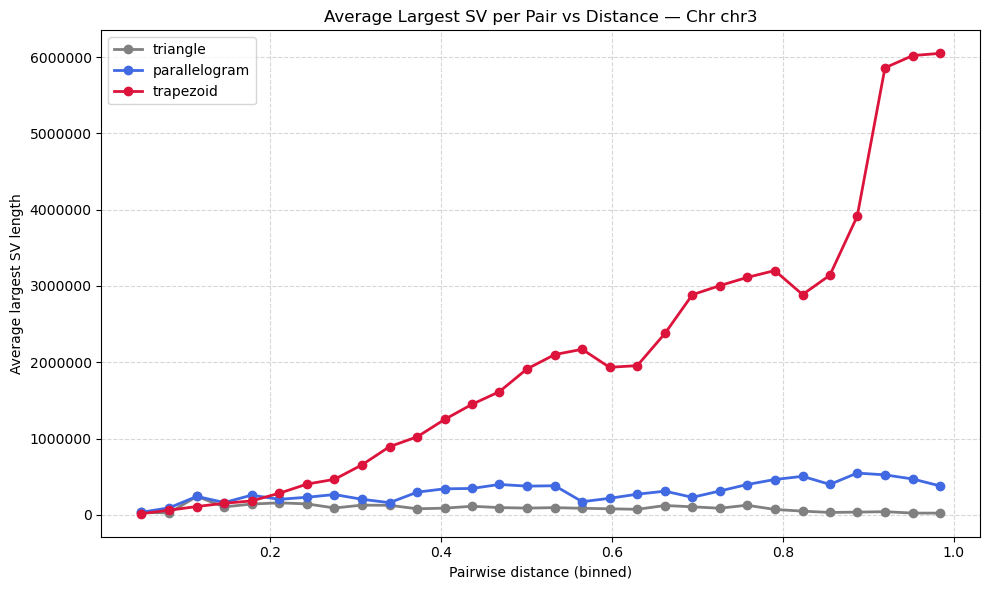

Processing chromosome: chr4


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


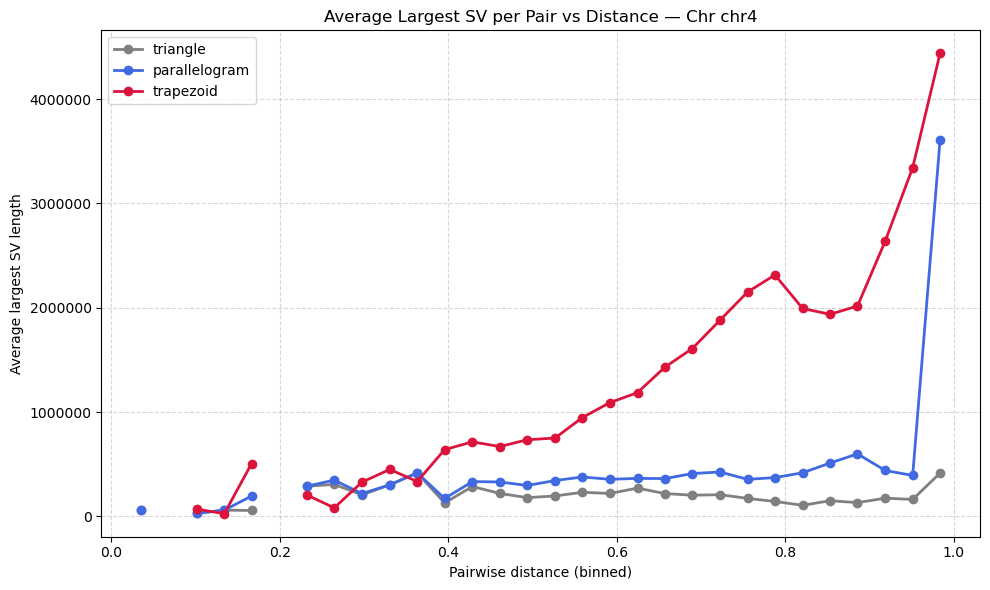

Processing chromosome: chr5


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


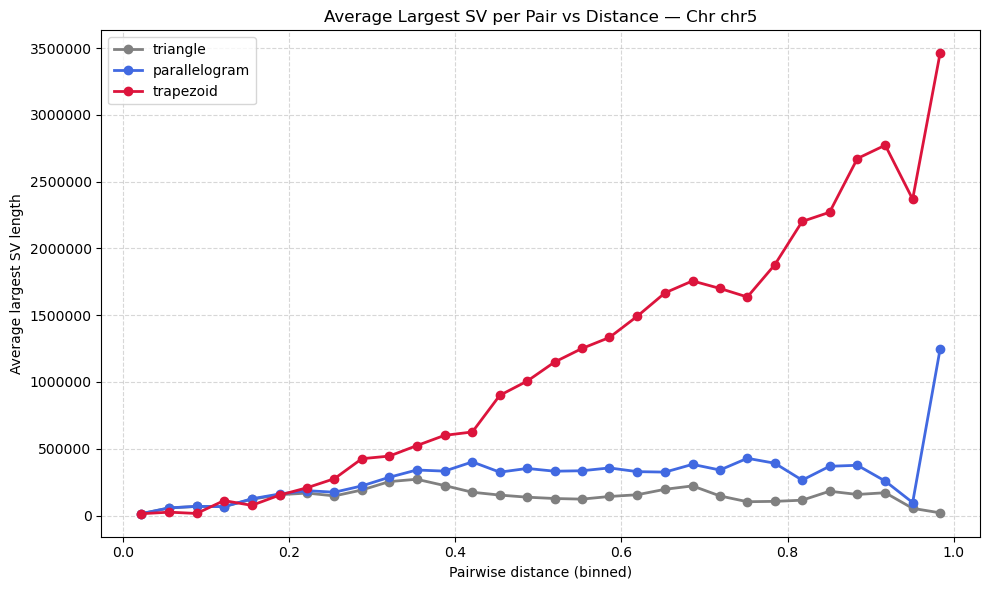

Processing chromosome: chr6


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


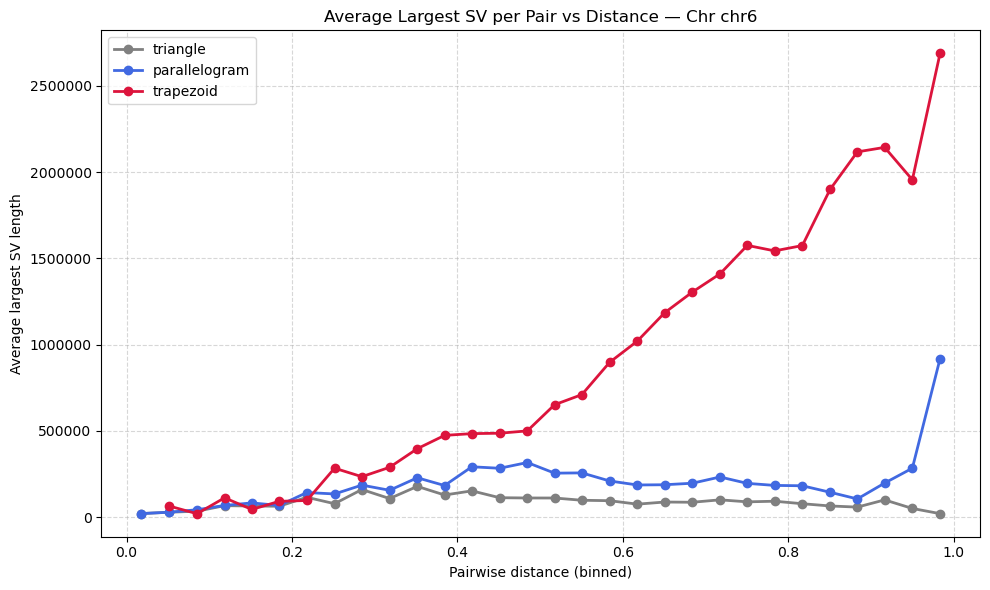

Processing chromosome: chr7


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


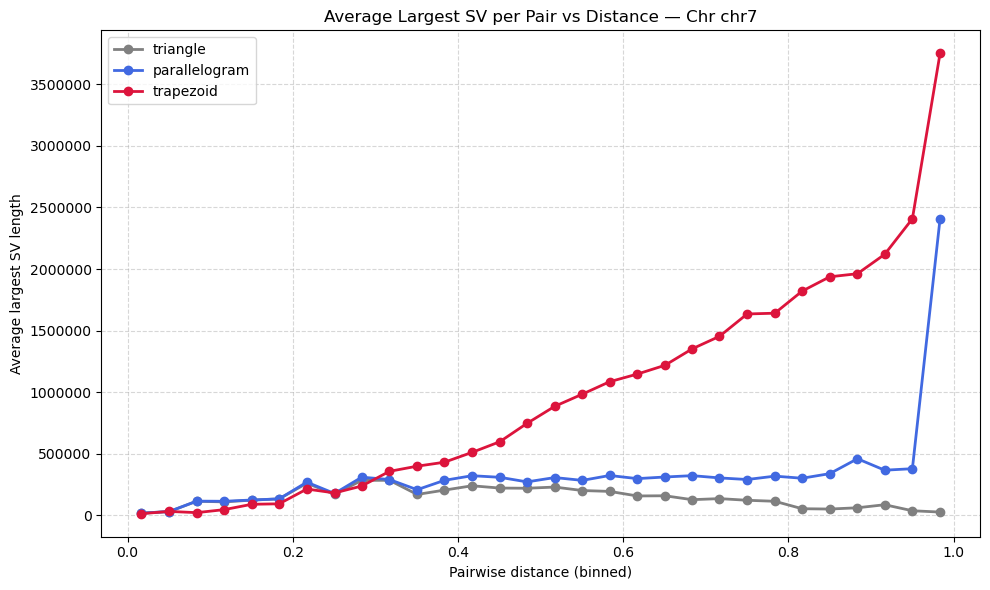

Processing chromosome: chr8


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


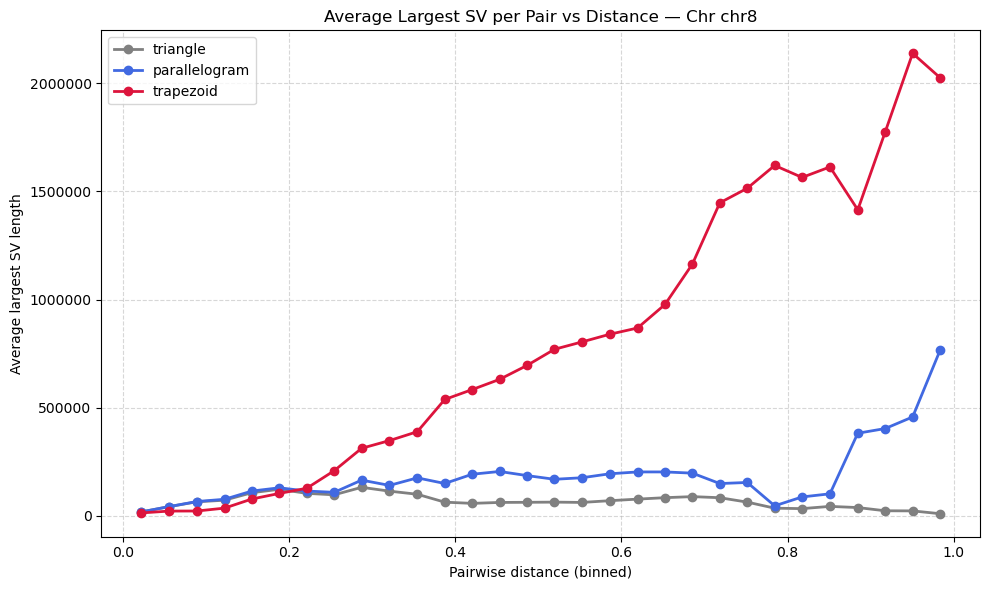

Processing chromosome: chr9


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


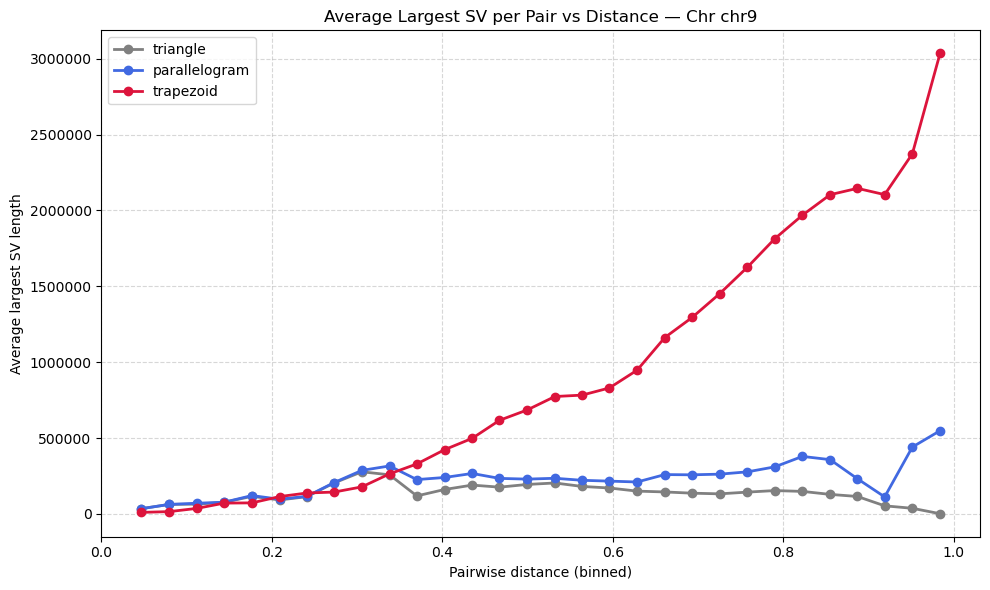

Processing chromosome: chrY


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


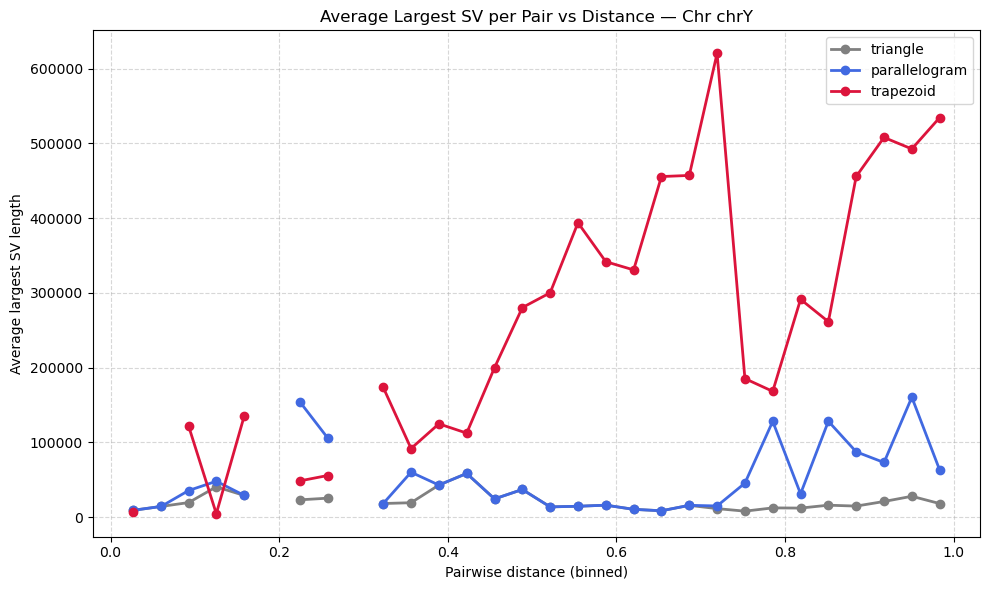

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Ensure sample_pair exists
df_sv_sorted["sample_pair"] = df_sv_sorted["sample1"] + "_" + df_sv_sorted["sample2"]

colors = {
    "triangle": "gray",
    "parallelogram": "royalblue",
    "trapezoid": "crimson"
}

# -------------------------------------------------------------------
# Function: largest SV per sample_pair
# -------------------------------------------------------------------
def get_largest_sv(subset):
    return (
        subset.sort_values("length", ascending=False)
              .groupby("sample_pair", as_index=False)
              .first()
    )   # keep the row containing the largest SV per sample_pair


# -------------------------------------------------------------------
# Loop over chromosomes
# -------------------------------------------------------------------
for chr_val in sorted(df_sv_sorted["chr"].unique()):

    print(f"Processing chromosome: {chr_val}")

    df_chr = df_sv_sorted[df_sv_sorted["chr"] == chr_val].copy()

    # convert distances
    df_chr["pairwise_dist"] = pd.to_numeric(df_chr["pairwise_dist"], errors="coerce")
    df_chr = df_chr.dropna(subset=["pairwise_dist"])

    # -------------------------------------------
    # define bins *per chromosome*
    # -------------------------------------------
    n_bins = 30
    df_chr["dist_bin"] = pd.cut(df_chr["pairwise_dist"], bins=n_bins)
    bin_categories = df_chr["dist_bin"].cat.categories

    # recreate masks but on df_chr
    conditions = {
        "triangle":      (df_chr["diff"] == -1),
        "parallelogram": (df_chr["diff"] < 0.1),
        "trapezoid":     (df_chr["diff"] > 0.1)
    }

    # -------------------------------------------
    # compute mean-largest-SV per bin per condition
    # -------------------------------------------
    plot_df = []

    for label, mask in conditions.items():
        subset = df_chr[mask].copy()

        # largest SV per sample pair
        largest = get_largest_sv(subset)

        # assign bins based on chromosome-specific edges
        largest["dist_bin"] = pd.cut(largest["pairwise_dist"], bins=bin_categories)

        stats = (
            largest.groupby("dist_bin")["length"]
                   .mean()
                   .reset_index(name="mean_length")
        )
        stats["condition"] = label
        plot_df.append(stats)

    plot_df = pd.concat(plot_df, ignore_index=True)

    # -------------------------------------------
    # Plot
    # -------------------------------------------
    fig, ax = plt.subplots(figsize=(10, 6))

    for label in ["triangle", "parallelogram", "trapezoid"]:
        df_c = plot_df[plot_df["condition"] == label].copy()
        if df_c.empty:
            continue

        df_c["midpoint"] = df_c["dist_bin"].apply(lambda x: x.mid)

        ax.plot(
            df_c["midpoint"],
            df_c["mean_length"],
            marker="o",
            color=colors[label],
            linewidth=2,
            label=label
        )

    ax.set_xlabel("Pairwise distance (binned)")
    ax.set_ylabel("Average largest SV length")
    ax.set_title(f"Average Largest SV per Pair vs Distance — Chr {chr_val}")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

    yfmt = ScalarFormatter(useOffset=False)
    yfmt.set_scientific(False)
    ax.yaxis.set_major_formatter(yfmt)

    plt.tight_layout()
    plt.show()


In [15]:
## Subset the data frame to all pairs with distance < 0.6
df_sv_sorted['pairwise_dist'] = pd.to_numeric(df_sv_sorted['pairwise_dist'], errors='coerce')
df_subset = df_sv_sorted[df_sv_sorted['pairwise_dist'] <= 0.6].reset_index(drop=True)

In [16]:
## Save list of pairs passing 0.4 threshold 
out_prefix = "/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/pairwise_cutoffs"   # <-- change this

# loop over each chromosome present in the subset df
for chrom in df_subset['chr'].unique():
    chrom_df = df_subset[df_subset['chr'] == chrom].copy()
    
    # keep only sample1 and sample2
    pairs = chrom_df[['sample1', 'sample2']]
    
    # save as CSV with comma-separated values
    out_file = f"{out_prefix}/{chrom}.induced_MSA.dist_0.6.csv"
    pairs.to_csv(out_file, index=False, header=False)
    
    print(f"Saved: {out_file}")

Saved: /private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/pairwise_cutoffs/chr5.induced_MSA.dist_0.6.csv
Saved: /private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/pairwise_cutoffs/chr12.induced_MSA.dist_0.6.csv
Saved: /private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/pairwise_cutoffs/chr8.induced_MSA.dist_0.6.csv
Saved: /private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/pairwise_cutoffs/chr17.induced_MSA.dist_0.6.csv
Saved: /private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/pairwise_cutoffs/chr18.induced_MSA.dist_0.6.csv
Saved: /private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/pairwise_cutoffs/chr6.induced_MSA.dist_0.6.csv
Saved: /private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/pairwise_cutoffs/chr4.induced_MSA.dist_0.6.csv
Saved: /private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/pairwise_cutoffs/chr3.induced_MSA.dist_0.6.csv
Saved: /private/groups/patenlab/mira/centrolign/analysis/SVs_

In [18]:
# ensure pairwise_dist is numeric
df_sv_sorted['pairwise_dist'] = pd.to_numeric(df_sv_sorted['pairwise_dist'], errors='coerce')

# group by chromosome
result = []

for chrom, g in df_sv_sorted.groupby('chr'):

    total_pairs = len(g)

    pairs_le_04 = (g['pairwise_dist'] <= 0.4).sum()
    pairs_le_06 = (g['pairwise_dist'] <= 0.6).sum()
    pairs_le_08 = (g['pairwise_dist'] <= 0.8).sum()

    # unique samples from both sample1 and sample2 columns
    samples = pd.unique(g[['sample1', 'sample2']].values.ravel())
    num_samples = len(samples)

    result.append({
        "chr": chrom,
        "num_samples": num_samples,
        "total_pairs": total_pairs,
        "pairs_le_0_4": pairs_le_04,
        "pairs_le_0_6": pairs_le_06,
        "pairs_le_0_8": pairs_le_08
    })

summary_df = pd.DataFrame(result).sort_values(by="chr")

summary_df.to_csv("/private/groups/patenlab/mira/chromosome_pair_counts.csv", index=False)

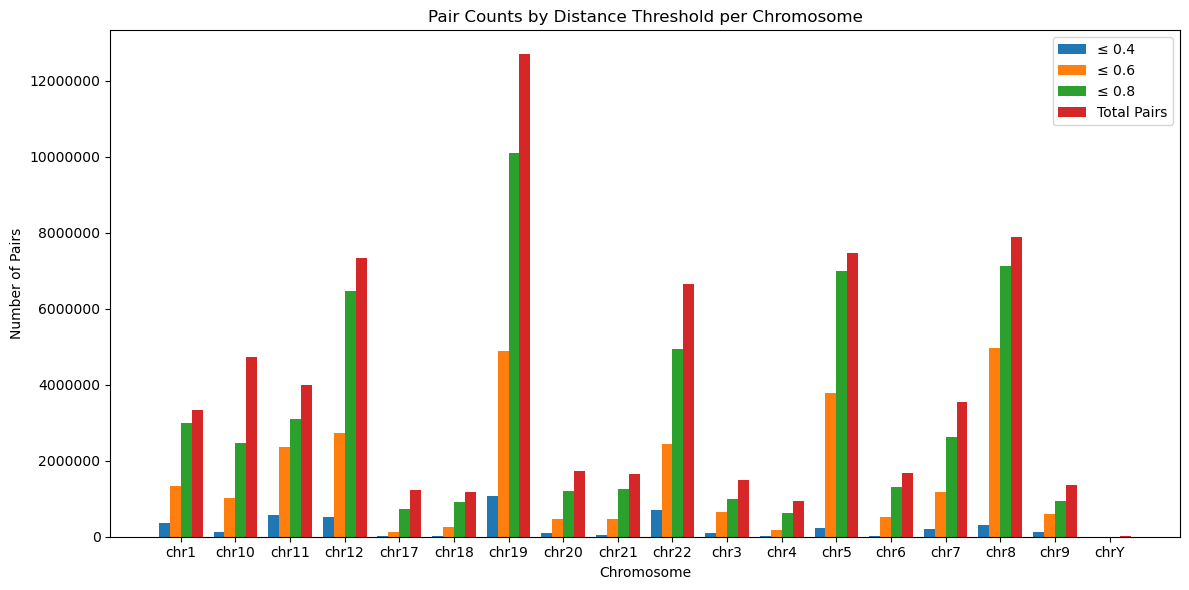

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# columns to plot
cols = ["pairs_le_0_4", "pairs_le_0_6", "pairs_le_0_8", "total_pairs"]
labels = ["≤ 0.4", "≤ 0.6", "≤ 0.8", "Total Pairs"]

# x positions for chromosomes
x = np.arange(len(summary_df['chr']))
width = 0.2  # width of each bar
fig, ax = plt.subplots(figsize=(12, 6))

# offsets for each bar
offsets = [-1.5*width, -0.5*width, 0.5*width, 1.5*width]

# plot bars
for i, col in enumerate(cols):
    ax.bar(x + offsets[i], summary_df[col], width, label=labels[i])

# labels and formatting
ax.set_xlabel("Chromosome")
ax.set_ylabel("Number of Pairs")
ax.set_title("Pair Counts by Distance Threshold per Chromosome")
ax.set_xticks(x)
ax.set_xticklabels(summary_df["chr"])
ax.legend()

yfmt = ScalarFormatter(useOffset=False)
yfmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(yfmt)
plt.tight_layout()
plt.show()


In [25]:
def plot_length_distributions(df, output_prefix, chr, min_sv=None, max_sv=None, bin_size=1000, max_bin=50000):
    """
    Generate SV length histograms with configurable filtering and binning.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns: 'type', 'diff', and 'length'.
    output_prefix : str
        File path prefix for saving plots.
    min_sv : int, optional
        Minimum SV length (bp) to include in the plot. Default = None (no lower limit).
    max_sv : int, optional
        Maximum SV length (bp) to include in the plot. Default = None (no upper limit).
    bin_size : int, optional
        Size of each histogram bin in base pairs. Default = 1000.
    max_bin : int, optional
        Maximum bin cutoff; all SVs >= max_bin are grouped into the final bin. Default = 50,000 bp.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    # Ensure directory exists
    out_dir = os.path.dirname(output_prefix)
    if out_dir and not os.path.exists(out_dir):
        os.makedirs(out_dir)

    # Define filter conditions
    conditions = [
        ("triangle",  (df["diff"] == -1)),
        ("parallelogram",  (df["diff"] < 0.1)),
        ("trapezoid",  (df["diff"] > 0.1))
    ]

    for label, cond in conditions:
        subset = df[cond].copy()

        # Apply SV size filtering if requested
        if min_sv is not None:
            subset = subset[subset["length"] >= min_sv]
        if max_sv is not None:
            subset = subset[subset["length"] <= max_sv]

        if subset.empty:
            print(f"No SVs found for {label} within given size range.")
            continue

        # Cap lengths at max_bin for plotting/counting
        lengths = subset["length"].copy()
        lengths_capped = np.where(lengths >= max_bin, max_bin, lengths)

        # Define bins
        bin_start = min_sv if min_sv is not None else 0
        bins = np.arange(bin_start, max_bin + bin_size, bin_size)
        counts, bin_edges = np.histogram(lengths_capped, bins=bins)

        # Count SVs >= max_bin separately and add to final bin
        overflow_count = (lengths >= max_bin).sum()
        counts[-1] += overflow_count

        # Print bin counts
        # print(f"\n=== {label} ===")
        # print("Bin range (bp) | Count")
        # for i in range(len(counts) - 1):
        #     print(f"{int(bin_edges[i])}-{int(bin_edges[i+1]-1)} | {counts[i]}")
        # print(f">={max_bin}| {overflow_count}")

        # Plot histogram
        plt.figure(figsize=(10, 5))
        x_pos = bin_edges[:-1]

        plt.bar(
            x_pos,
            counts,
            width=bin_size,
            align='edge',
            color="skyblue",
            edgecolor="black",
            alpha=0.7
        )

        # Label x-axis
        x_labels = [str(int(edge)) for edge in bin_edges[:-1]] + [f">{max_bin/1000:.0f}kb"]
        plt.xticks(list(x_pos) + [max_bin], x_labels, rotation=90)

        plt.title(f"SV Length Distribution: {label} for {chr}")
        plt.xlabel("Length (bp)")
        plt.ylabel("Count")
        plt.tight_layout()

        output_file = f"{output_prefix}_{label}.png"
        #plt.savefig(output_file)
        #plt.close()
        plt.show()
        #print(f"Saved plot: {output_file}")

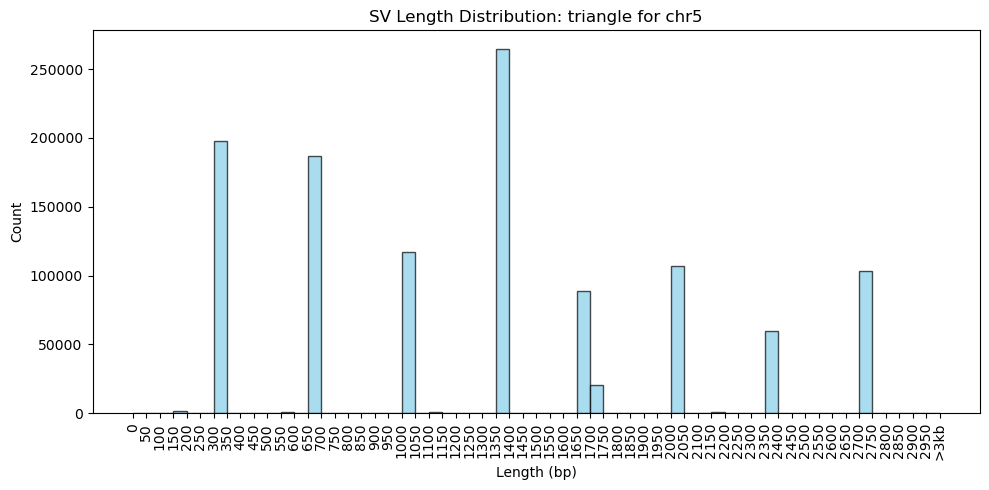

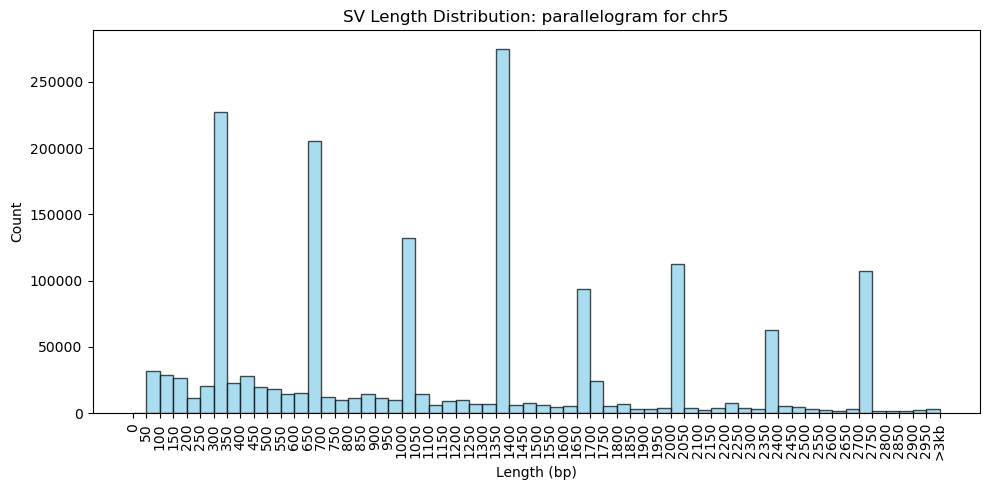

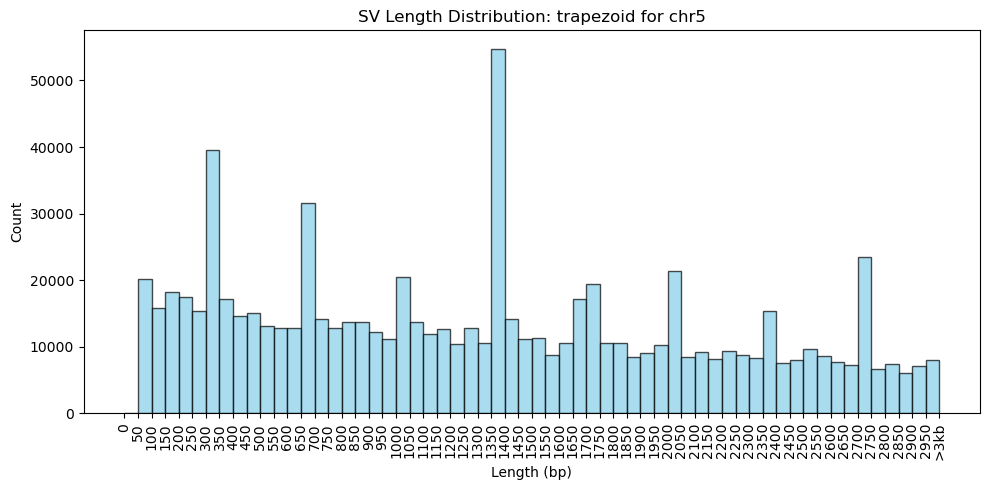

Plotted length distribution for chromosome chr5


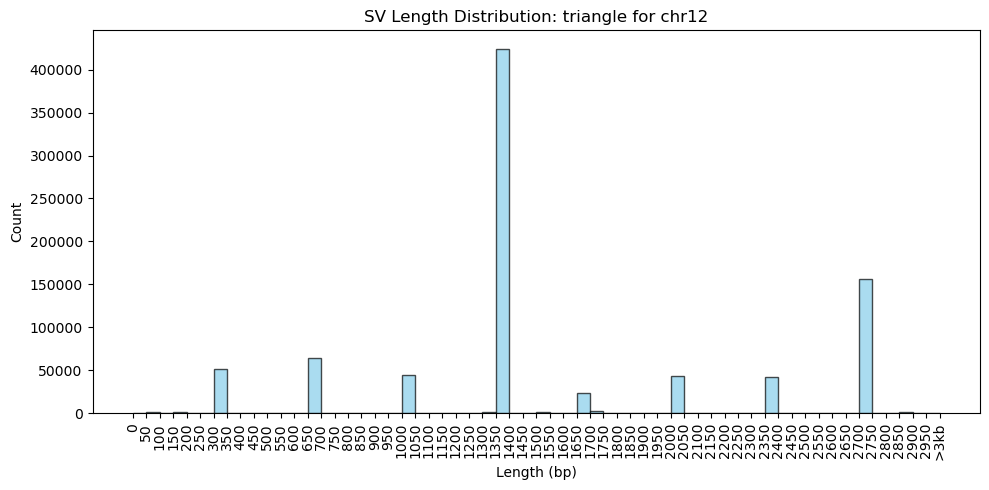

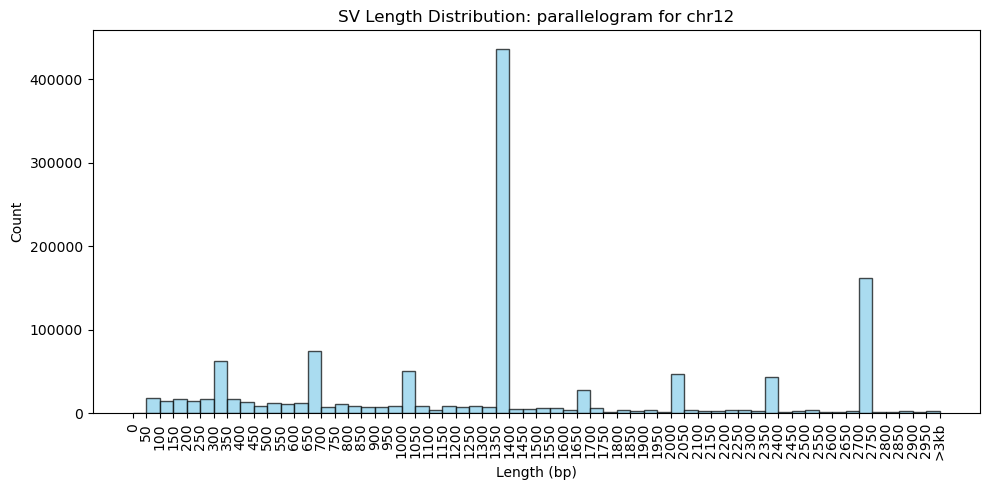

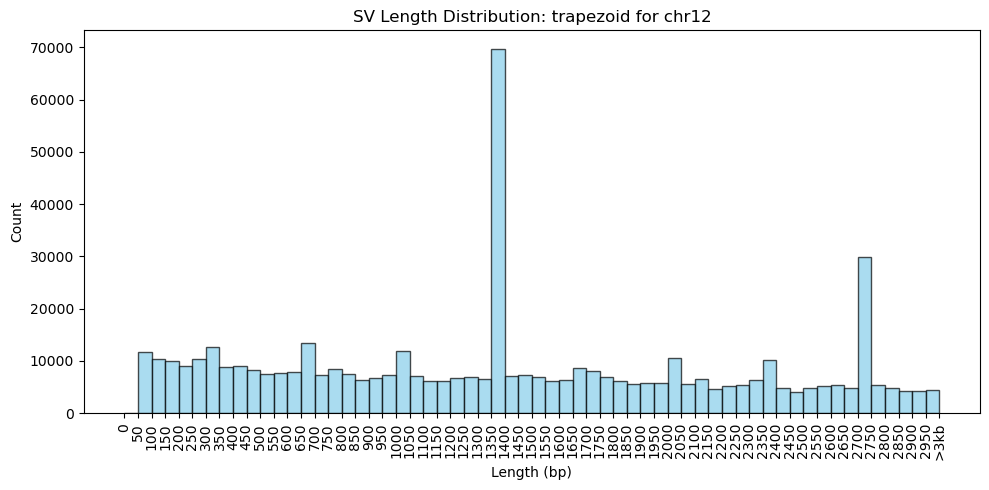

Plotted length distribution for chromosome chr12


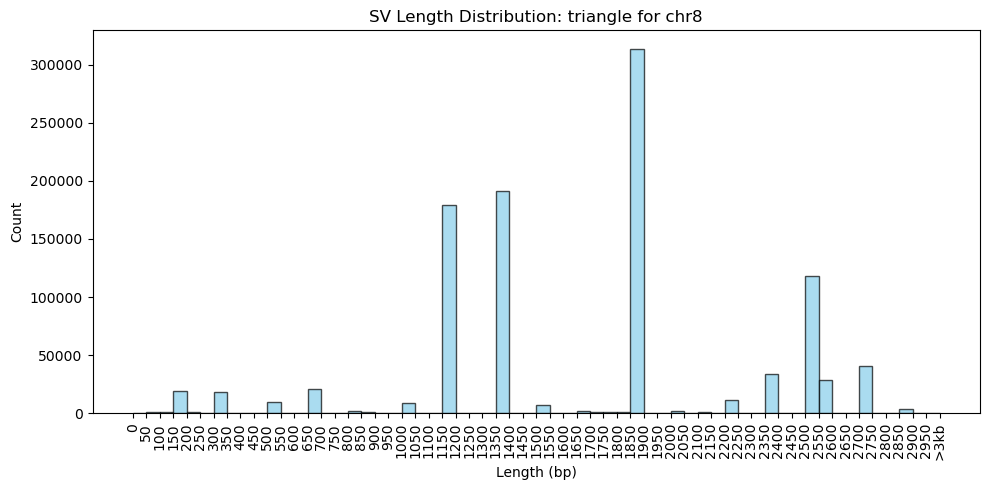

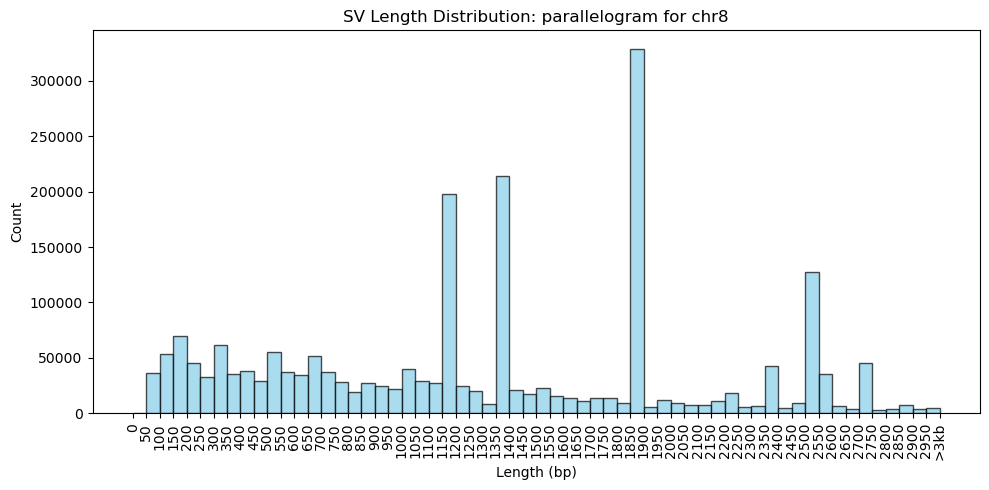

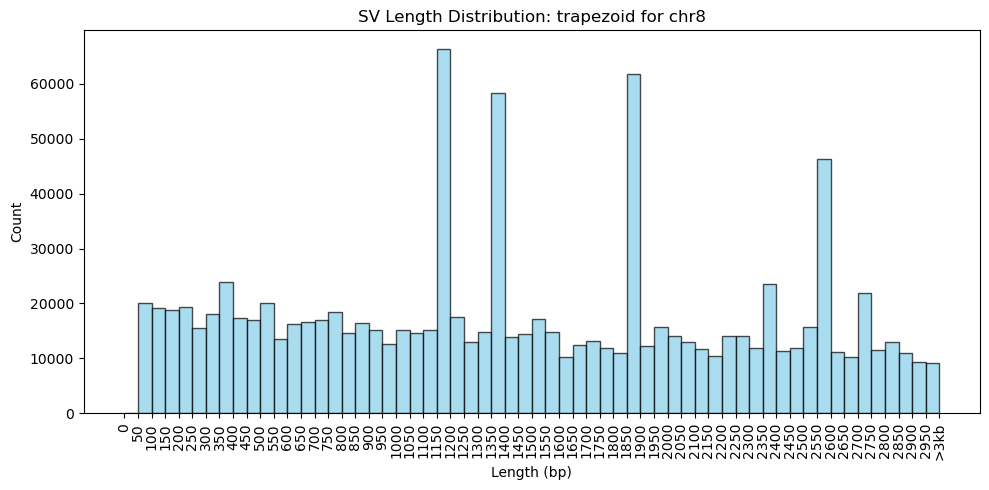

Plotted length distribution for chromosome chr8


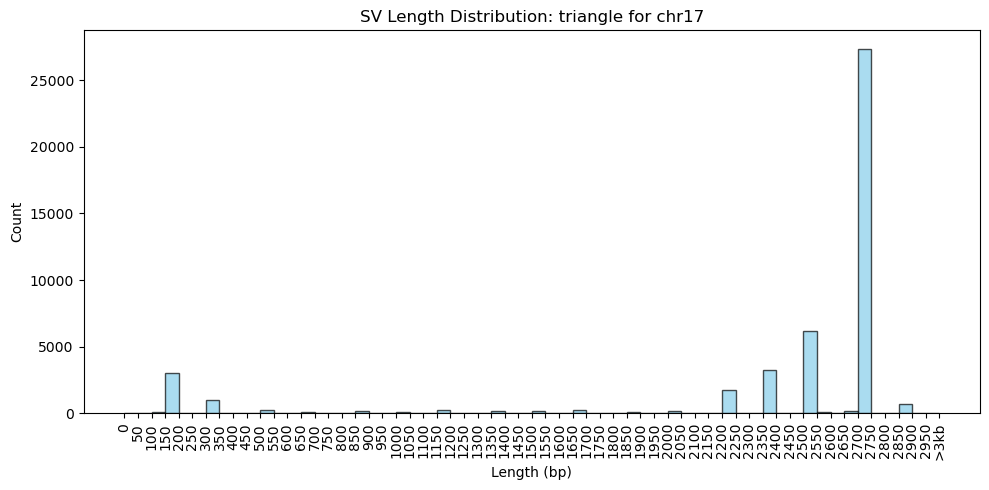

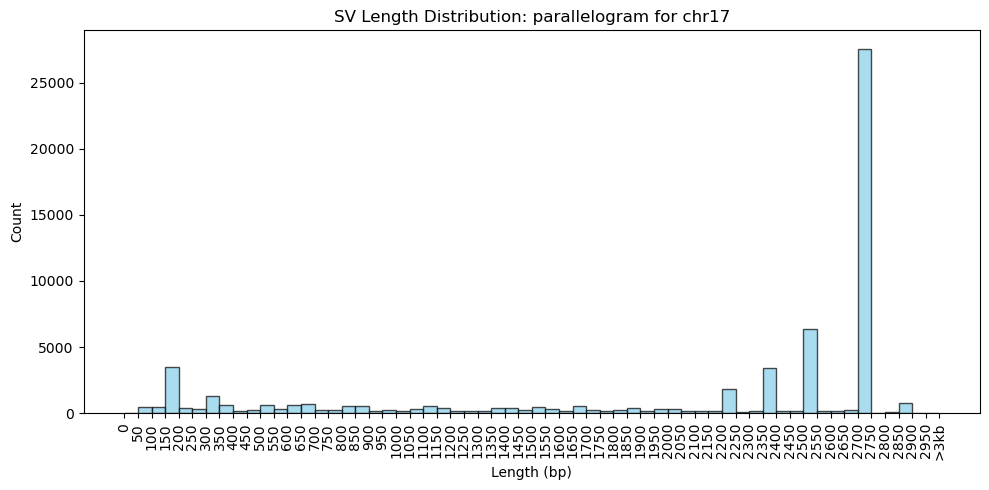

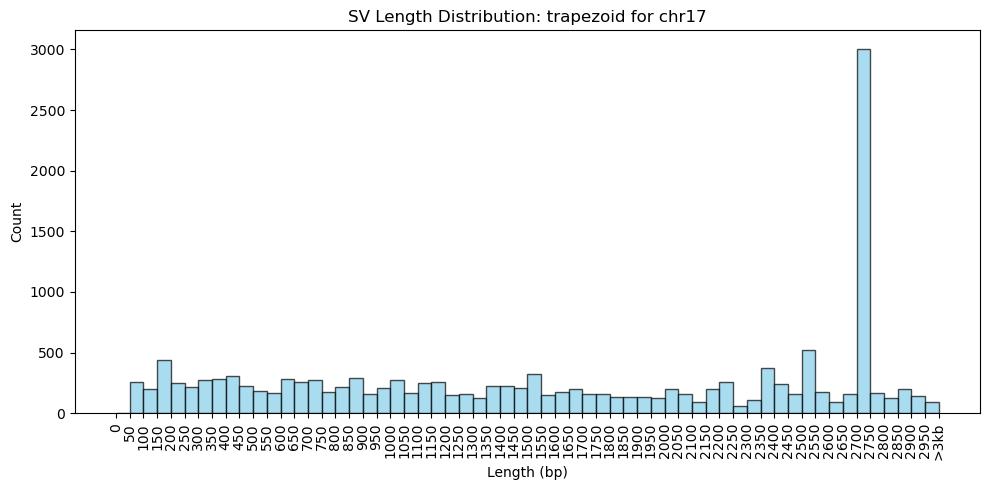

Plotted length distribution for chromosome chr17


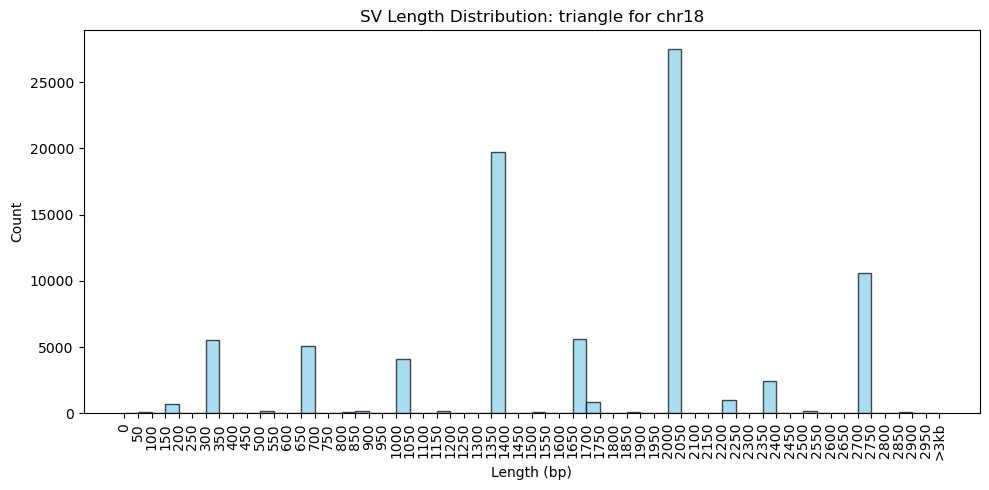

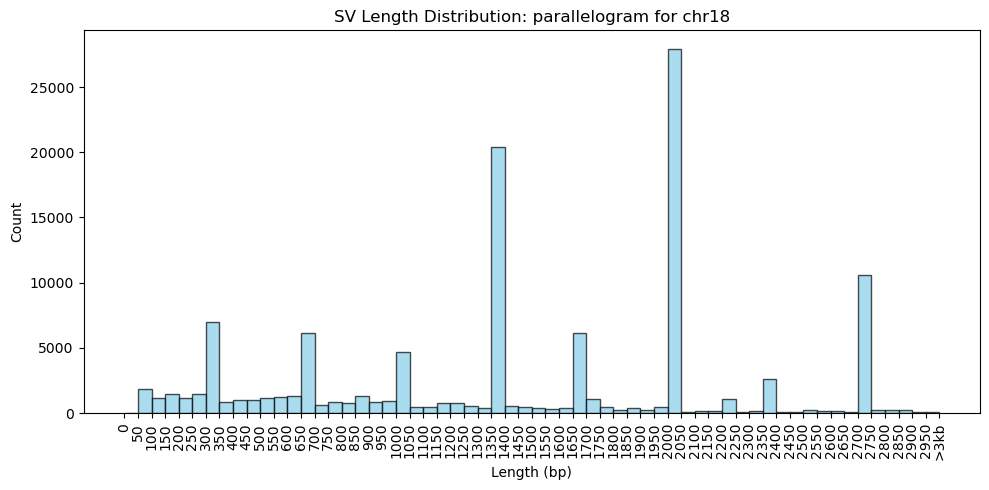

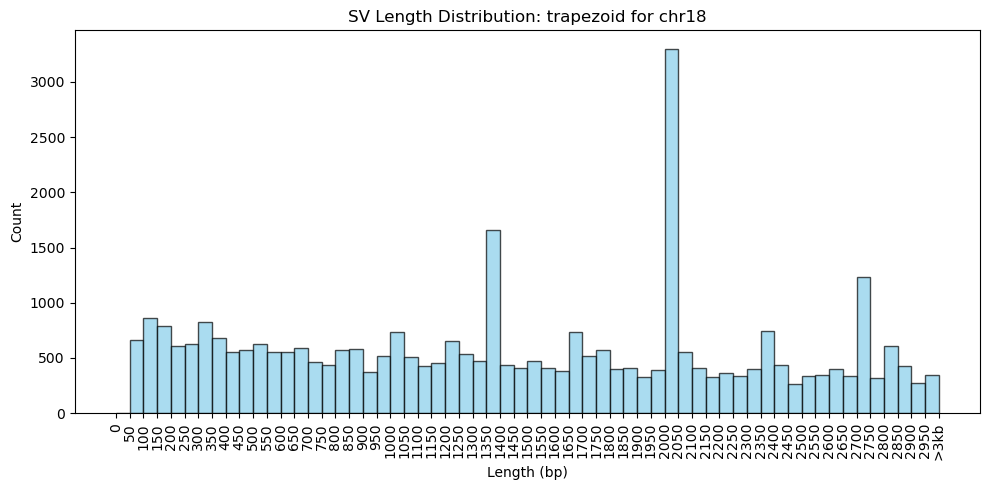

Plotted length distribution for chromosome chr18


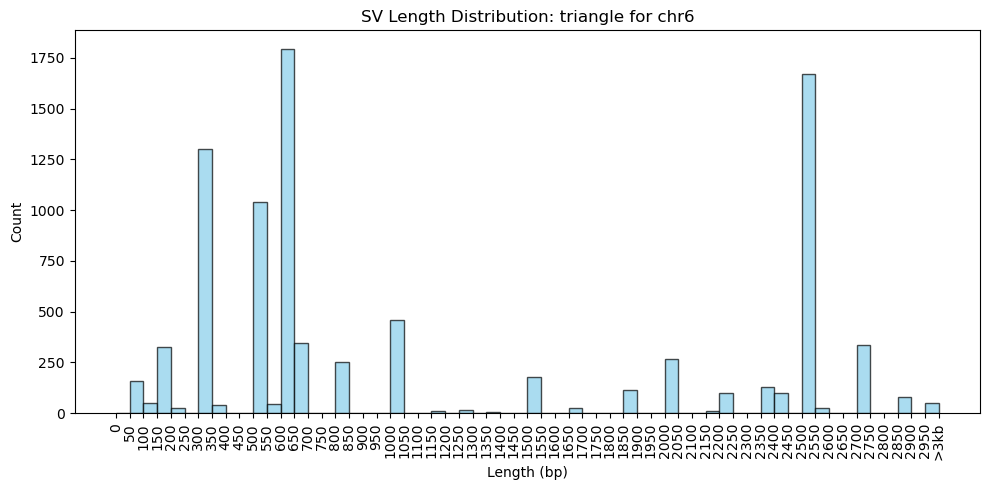

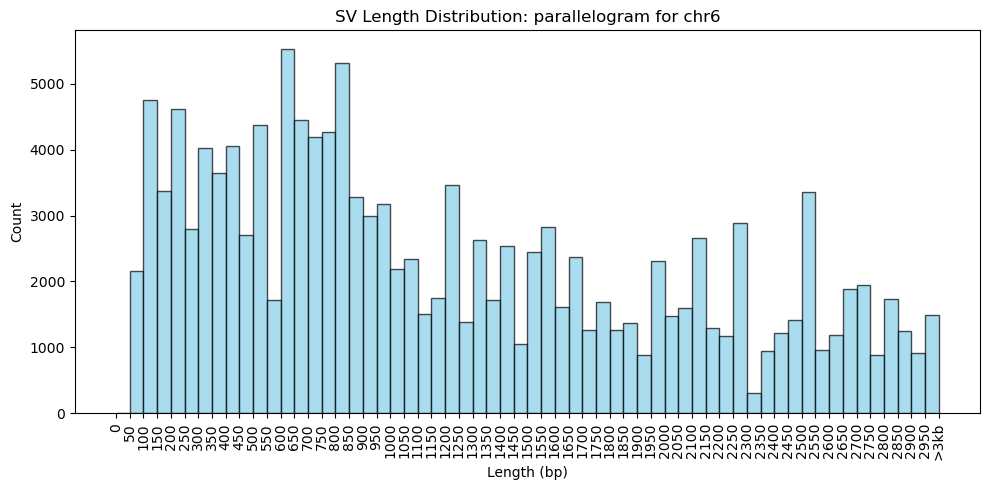

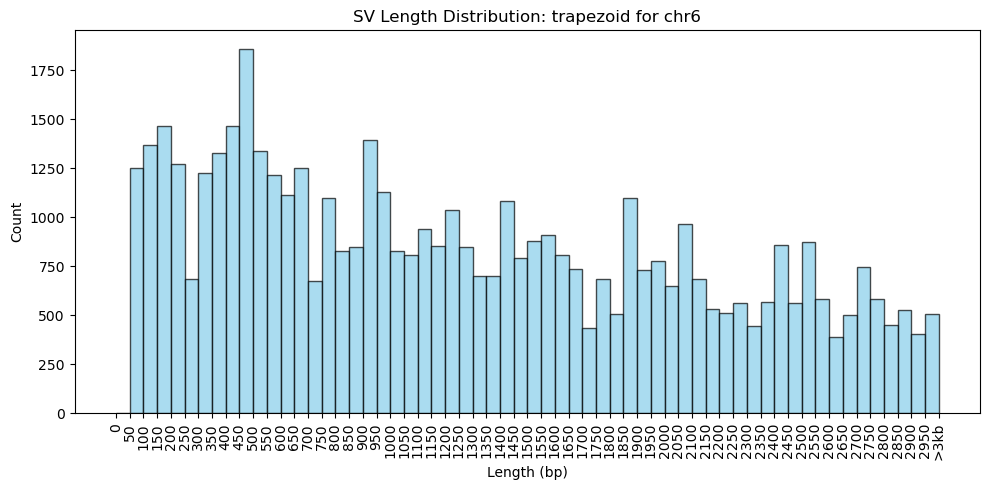

Plotted length distribution for chromosome chr6


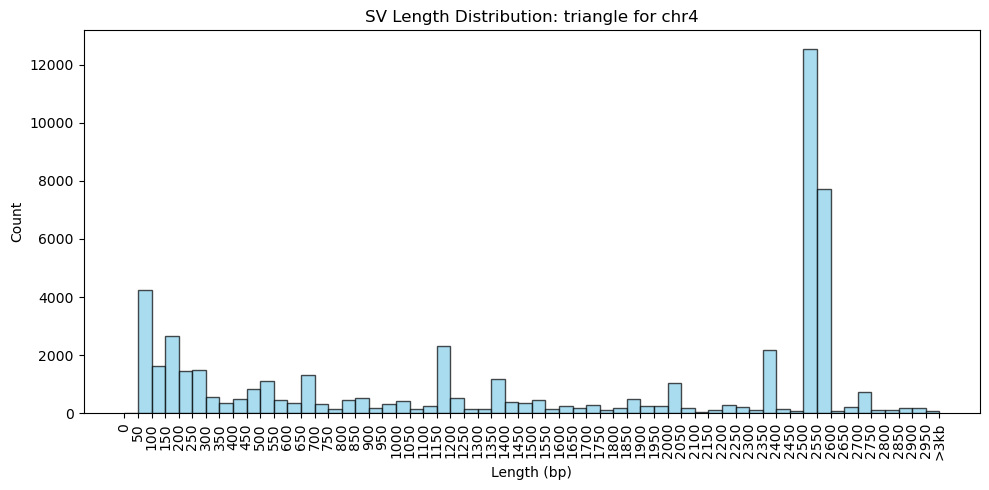

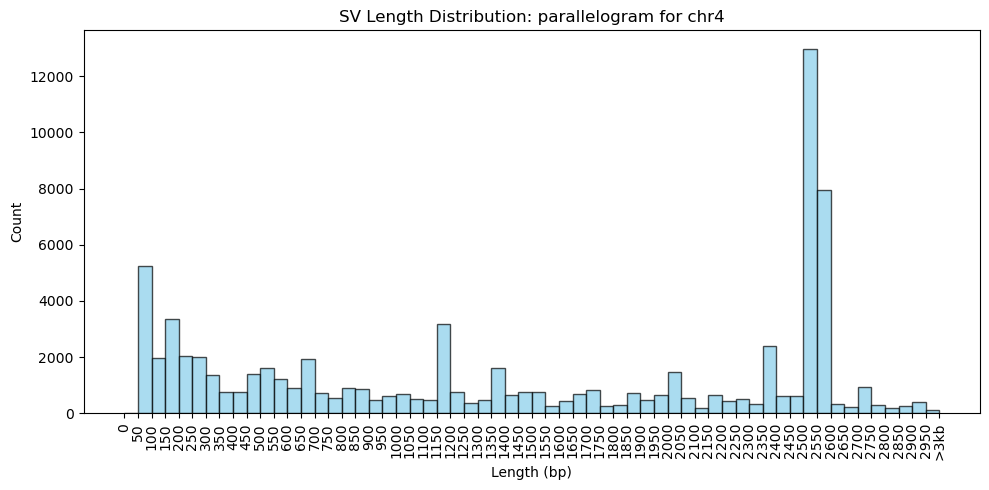

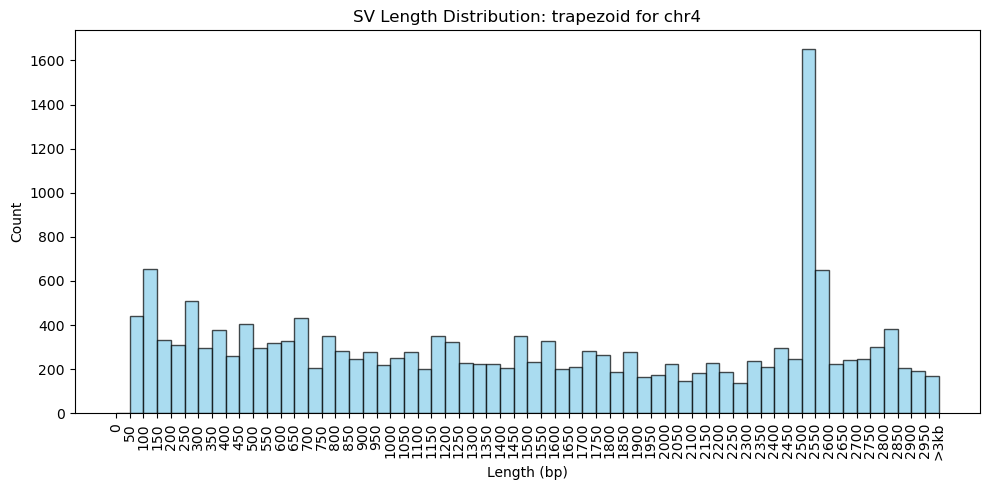

Plotted length distribution for chromosome chr4


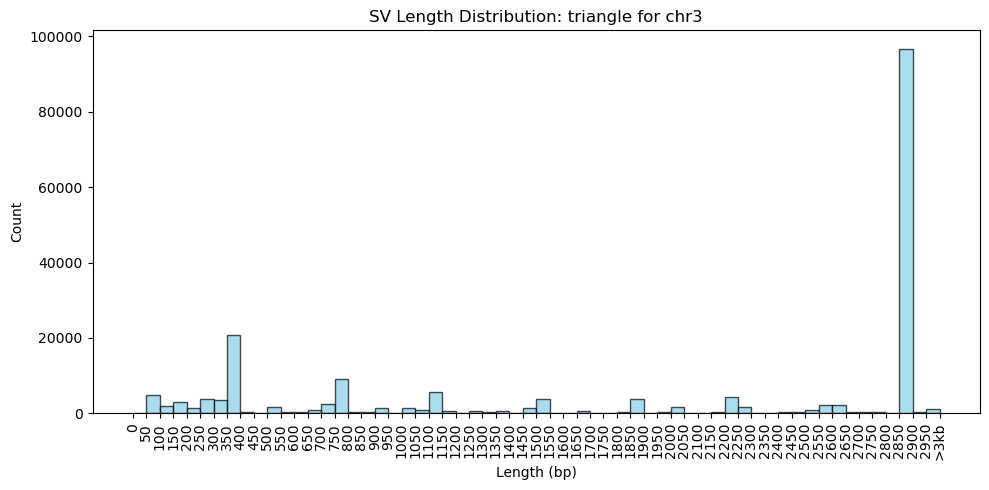

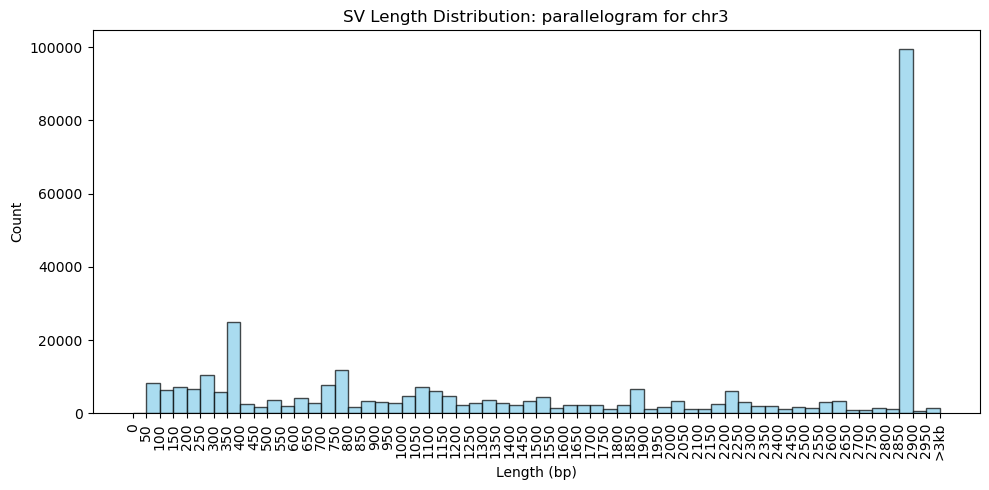

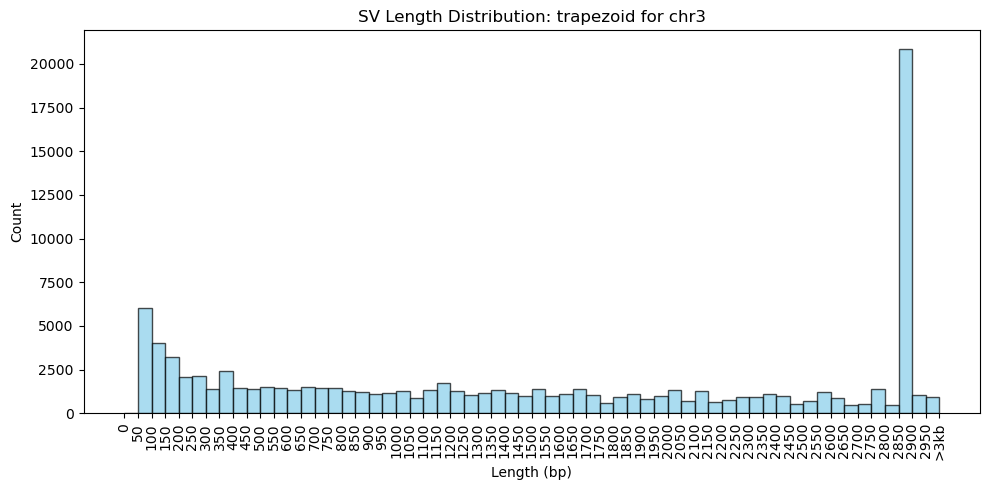

Plotted length distribution for chromosome chr3


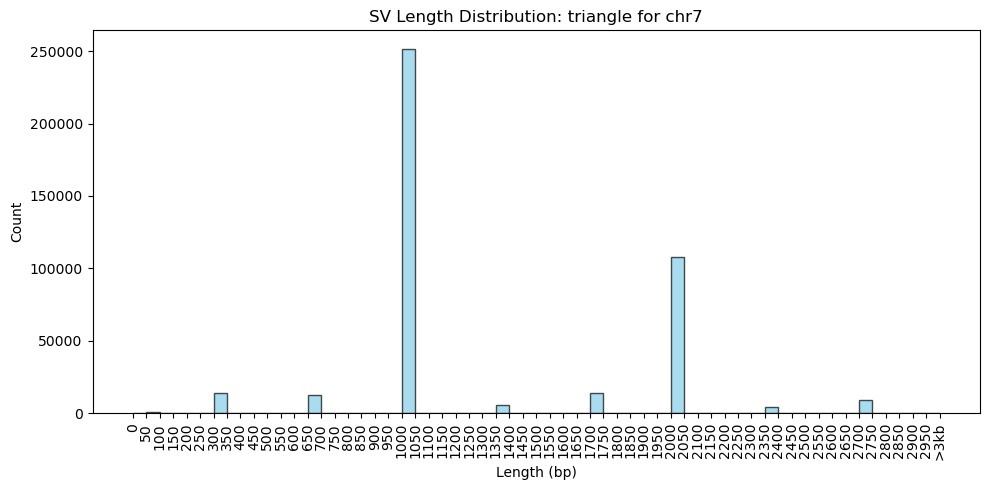

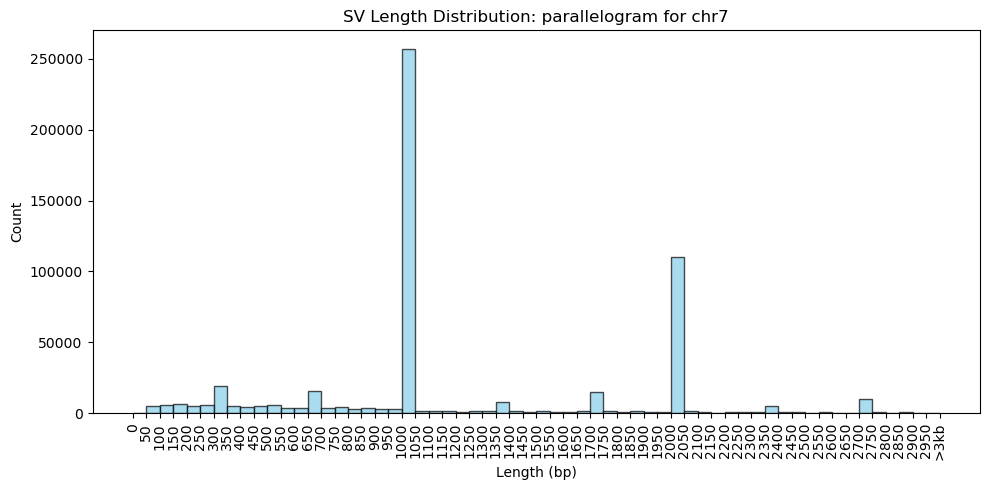

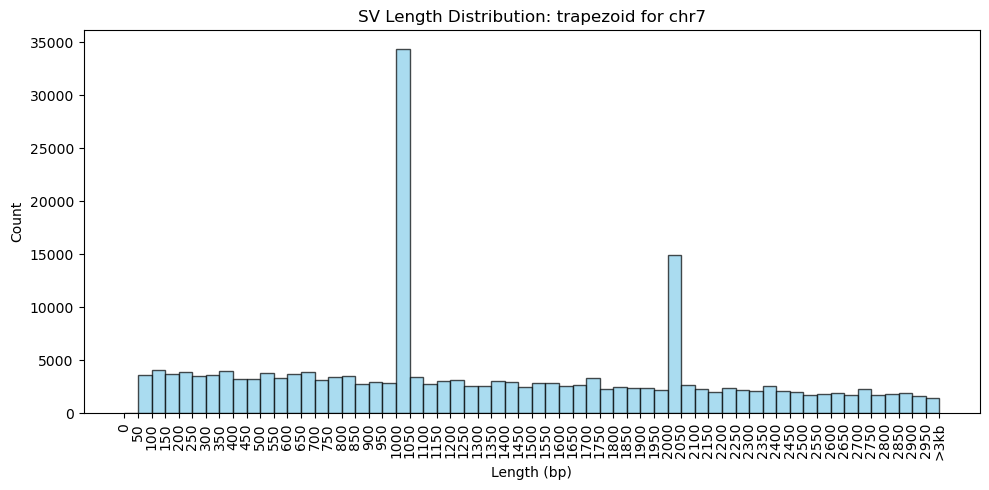

Plotted length distribution for chromosome chr7


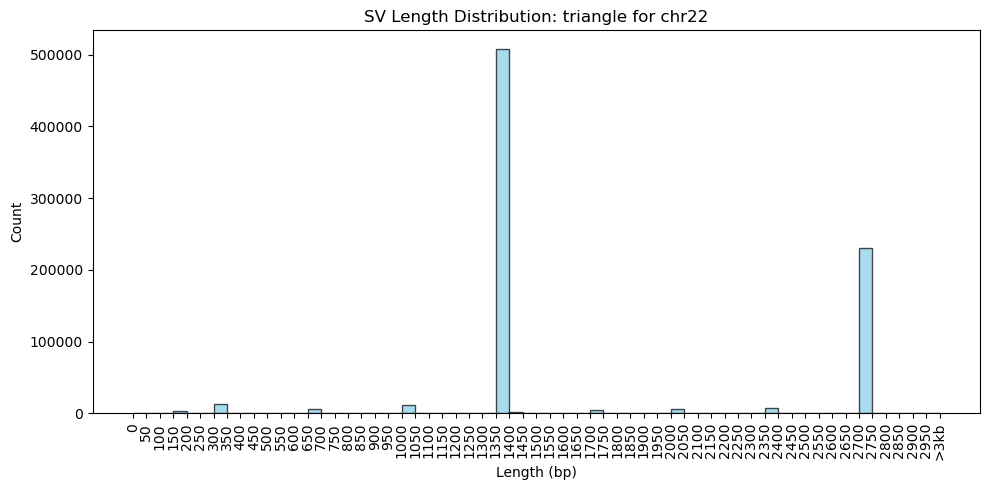

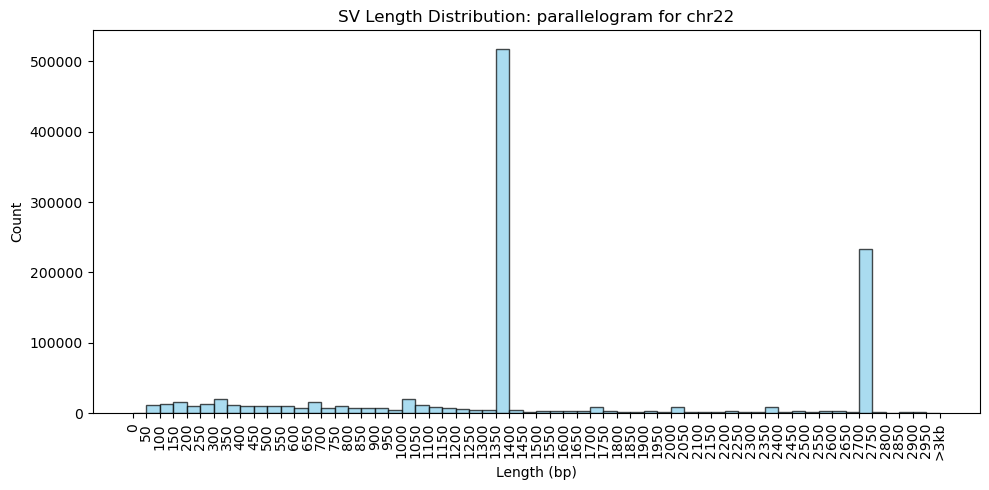

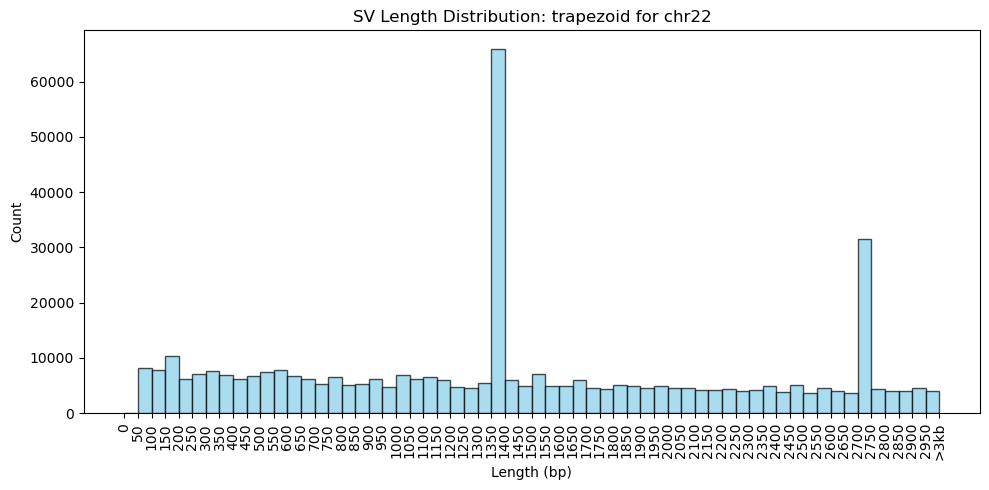

Plotted length distribution for chromosome chr22


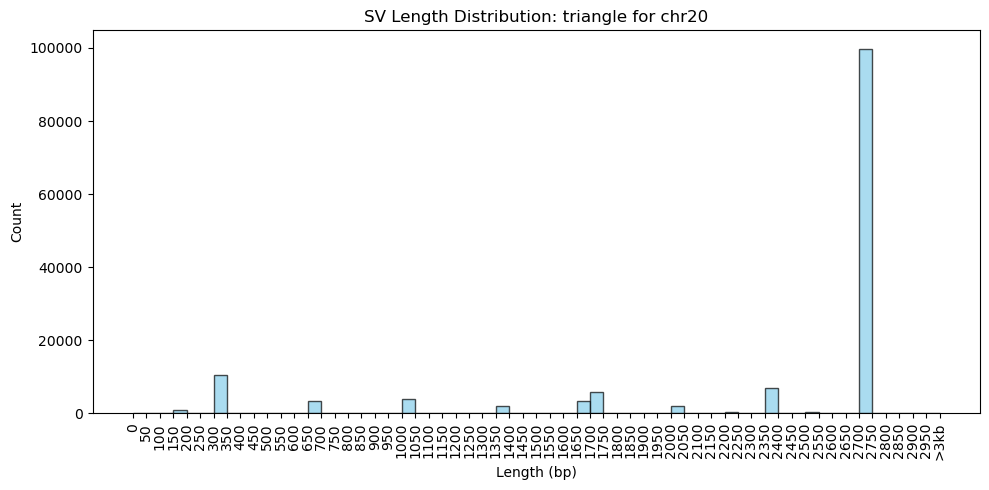

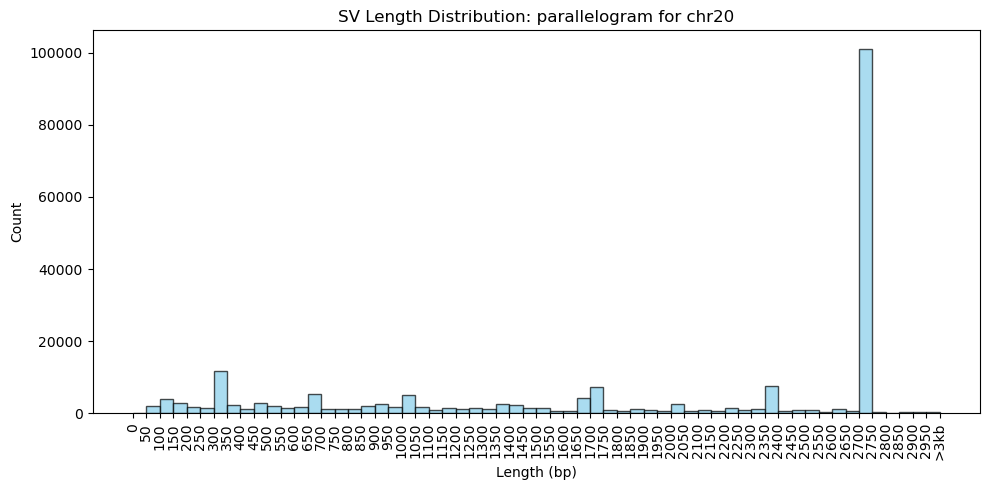

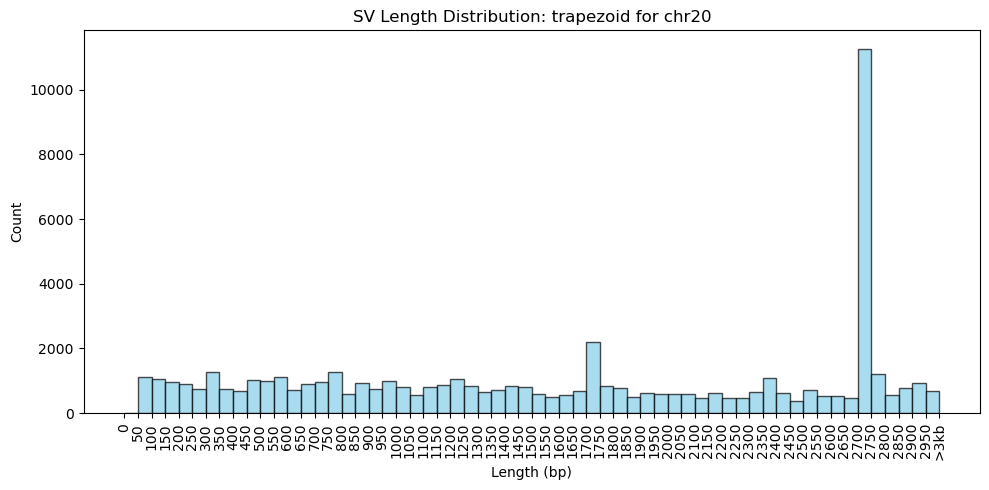

Plotted length distribution for chromosome chr20


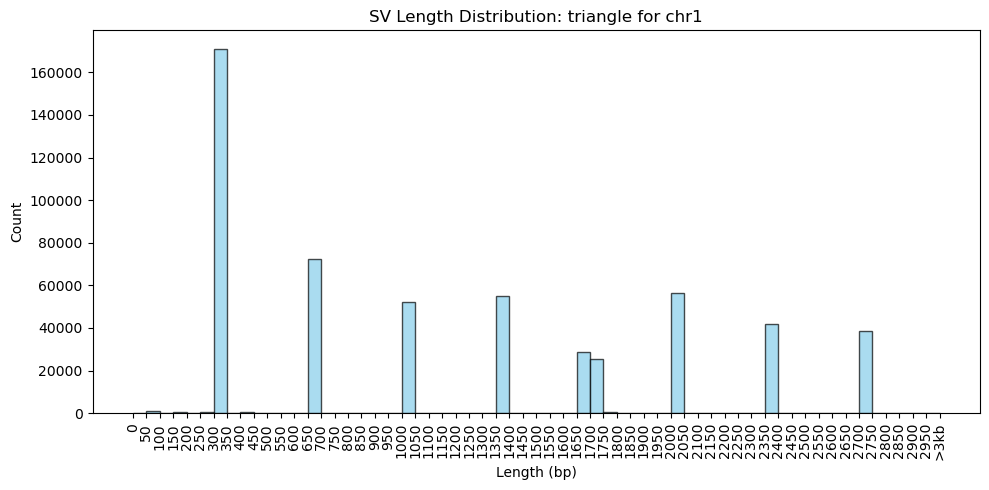

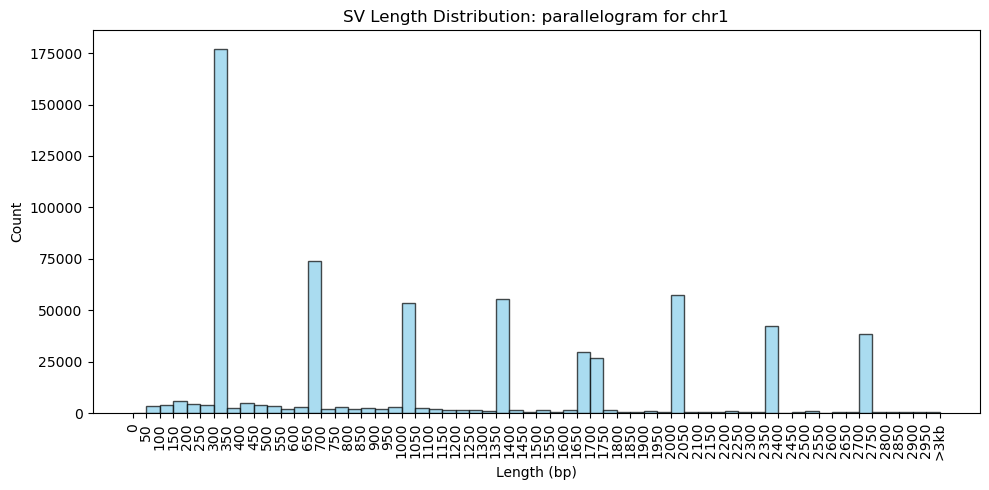

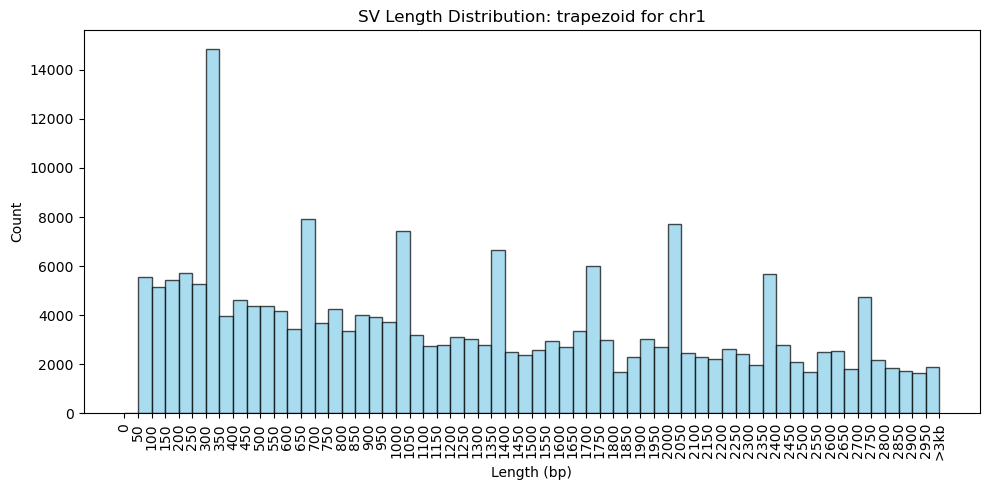

Plotted length distribution for chromosome chr1


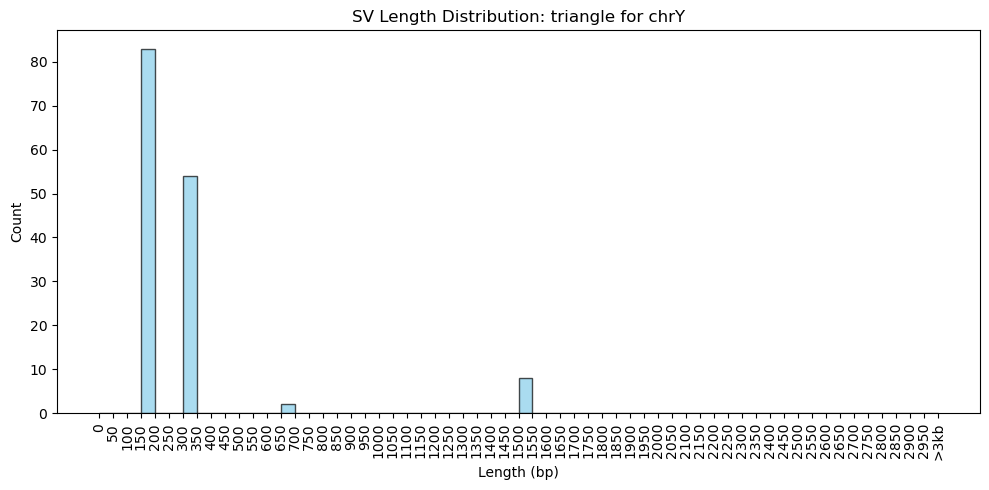

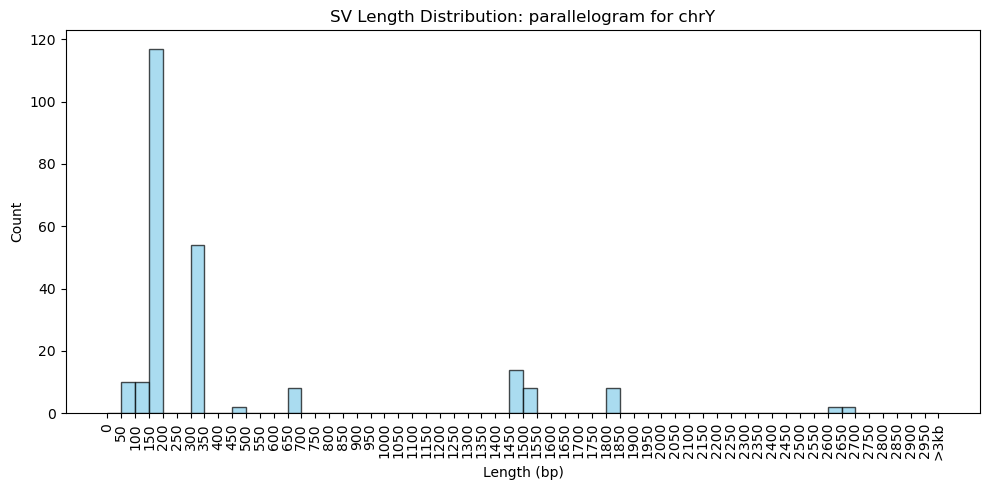

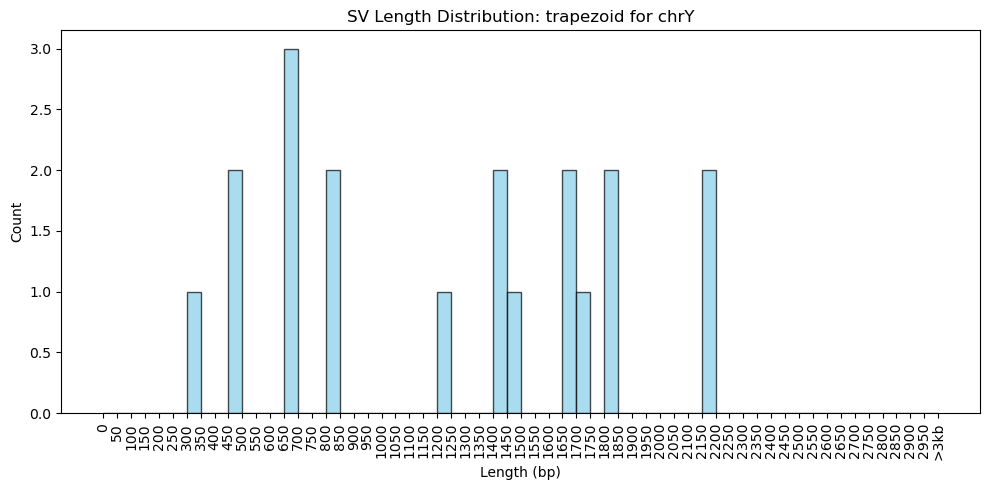

Plotted length distribution for chromosome chrY


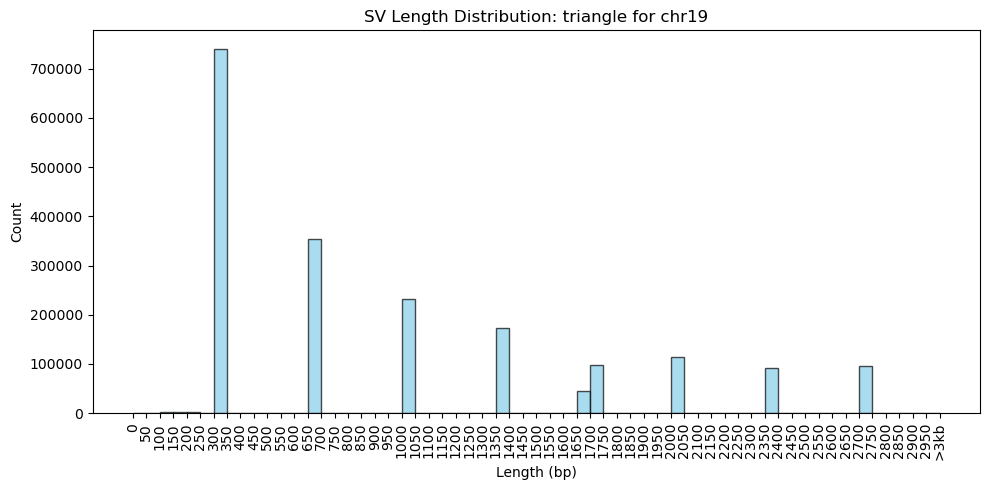

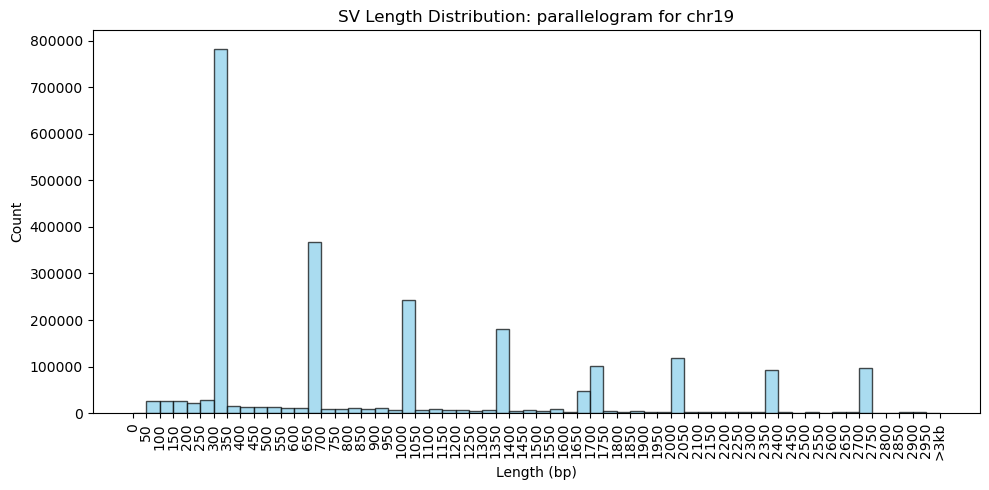

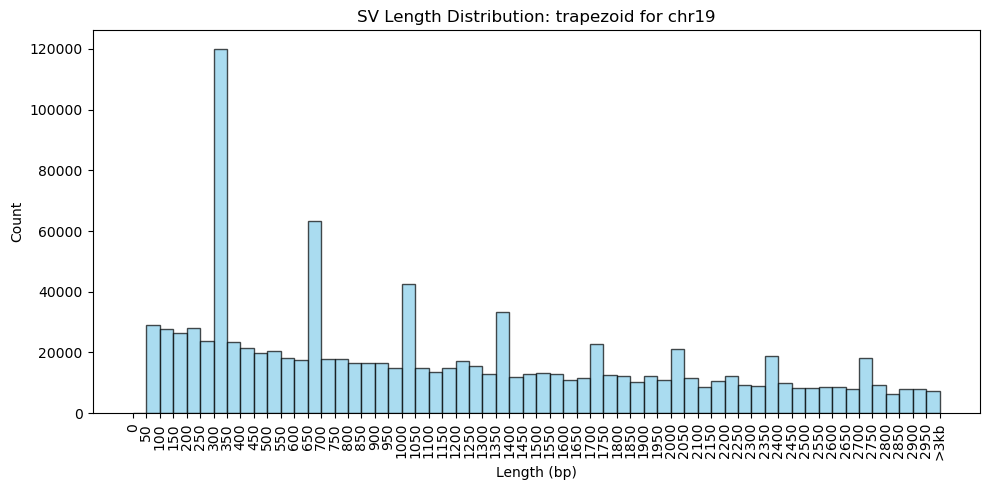

Plotted length distribution for chromosome chr19


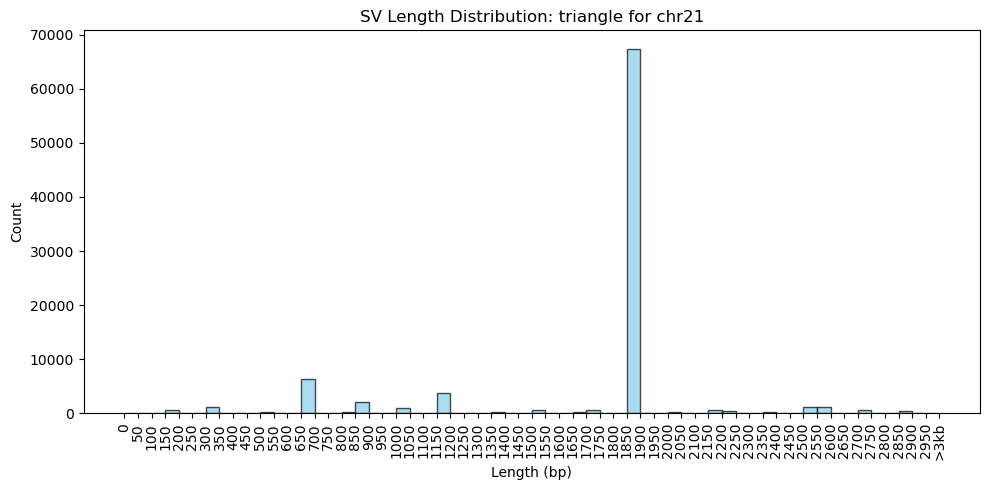

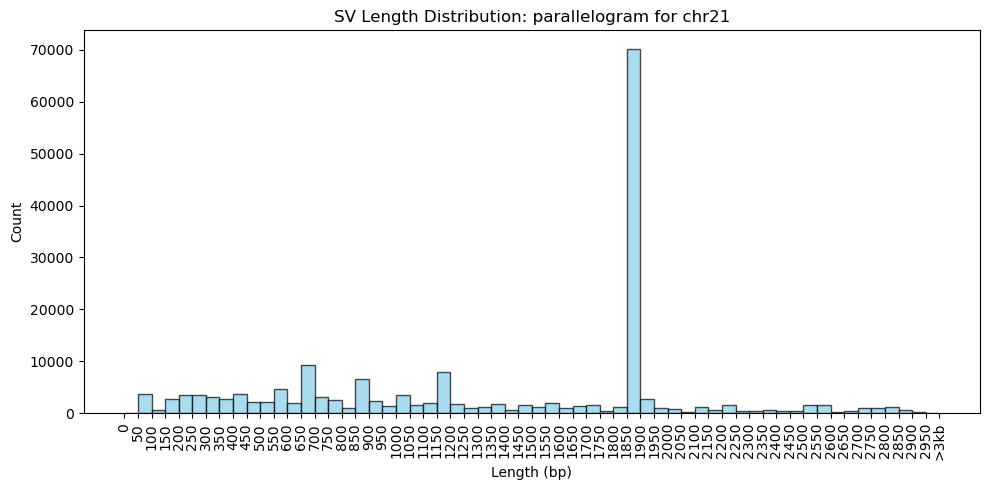

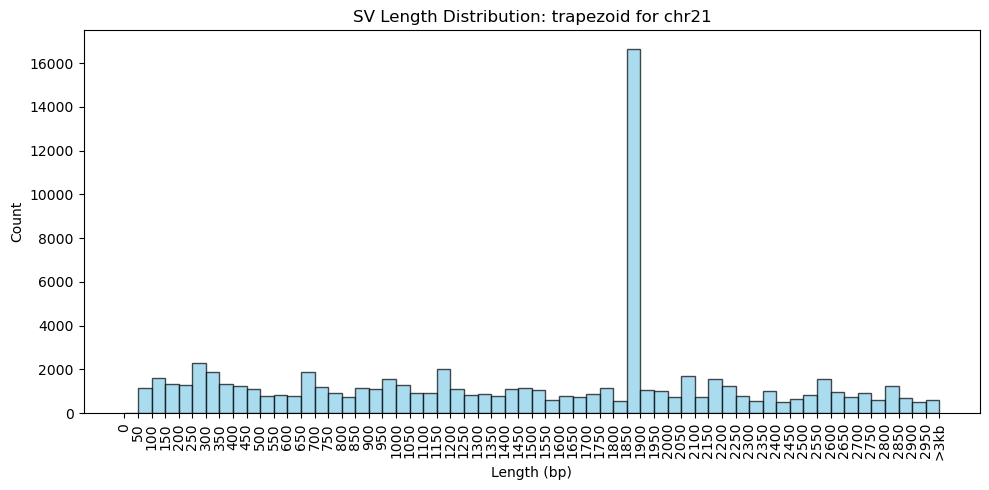

Plotted length distribution for chromosome chr21


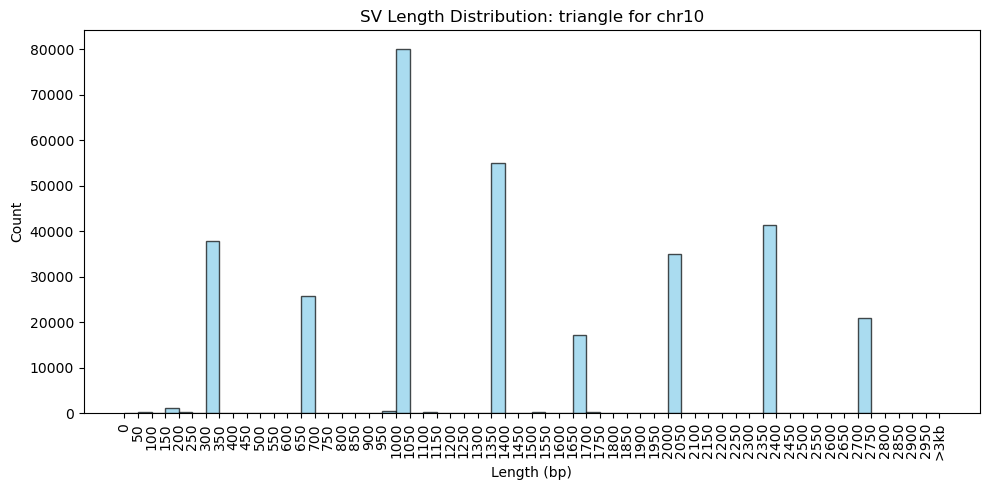

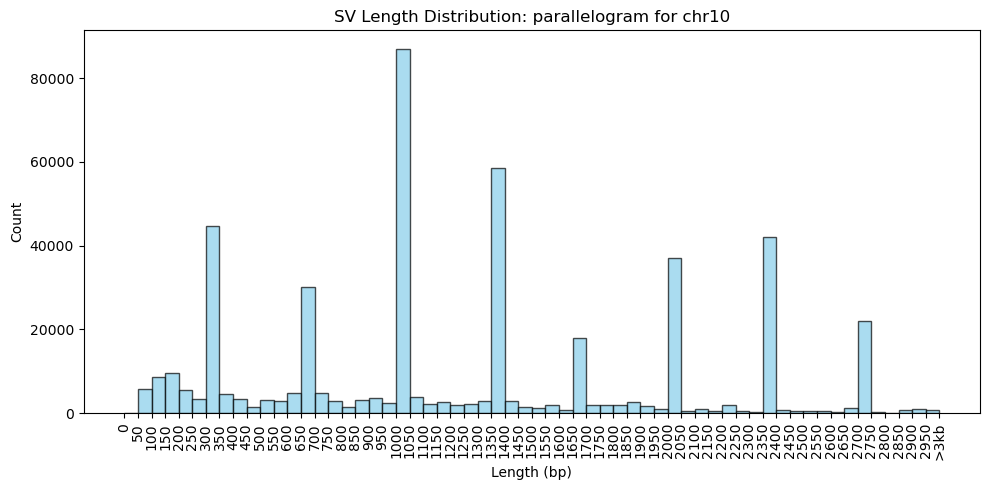

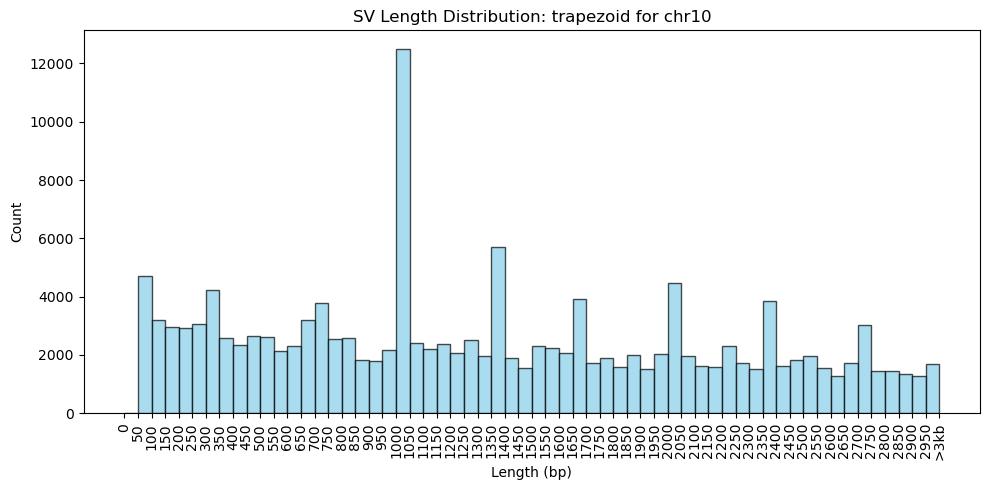

Plotted length distribution for chromosome chr10


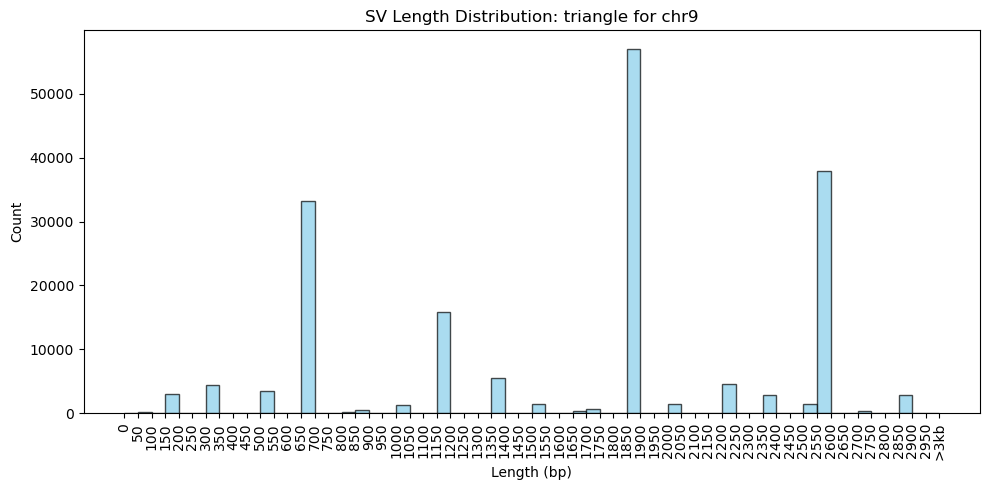

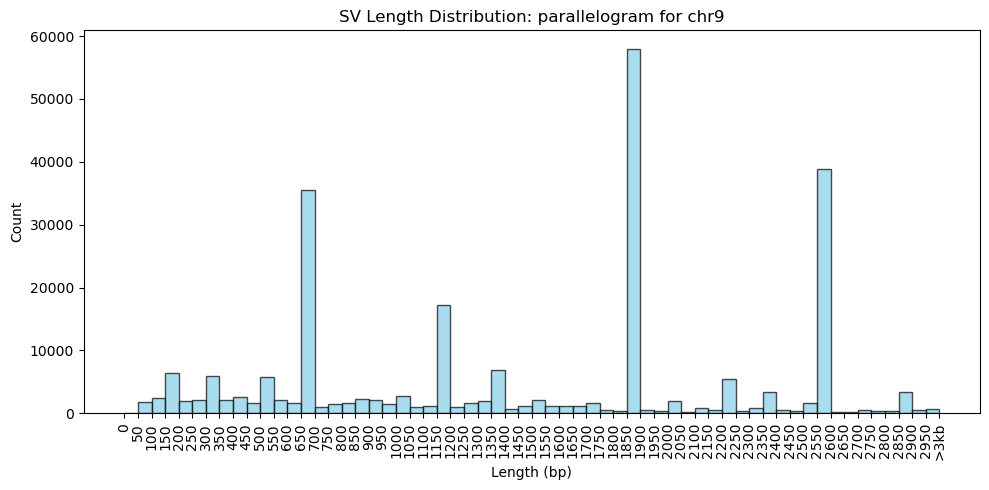

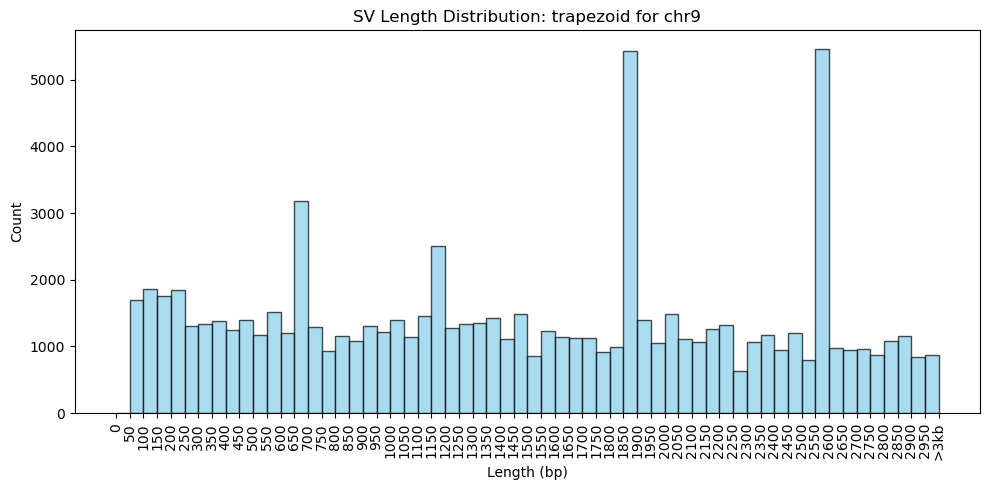

Plotted length distribution for chromosome chr9


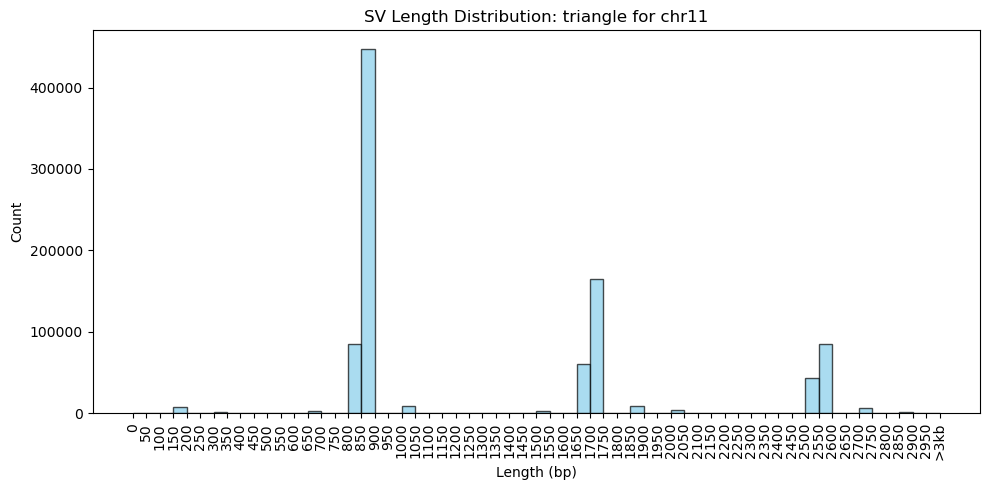

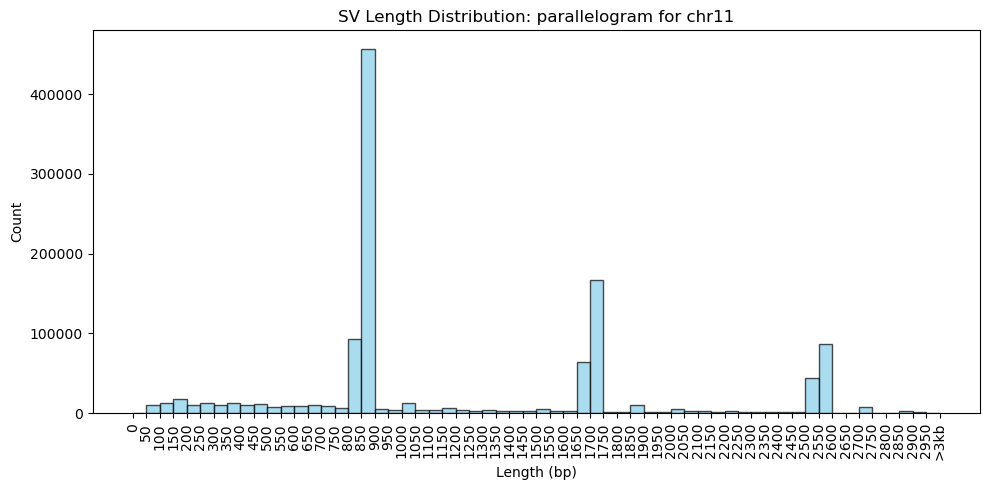

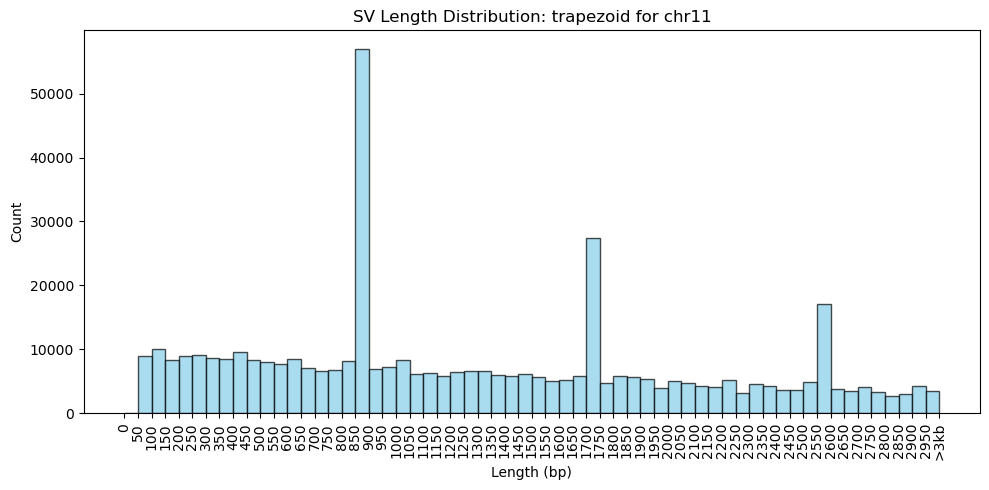

Plotted length distribution for chromosome chr11


In [26]:
plot_prefix = "my_plots_"  # change as needed

for chrom in df_subset['chr'].unique():
    # subset to this chromosome
    chrom_df = df_subset[df_subset['chr'] == chrom].copy()
    
    # build plot filename
    plot_file = f"{plot_prefix}SVs_1150_2kb_chr{chrom}"
    
    # call the plotting function
    plot_length_distributions(
        chrom_df,
        plot_file,
        chrom,
        max_sv=3000,
        bin_size=50,
        max_bin=3000
    )
    
    print(f"Plotted length distribution for chromosome {chrom}")

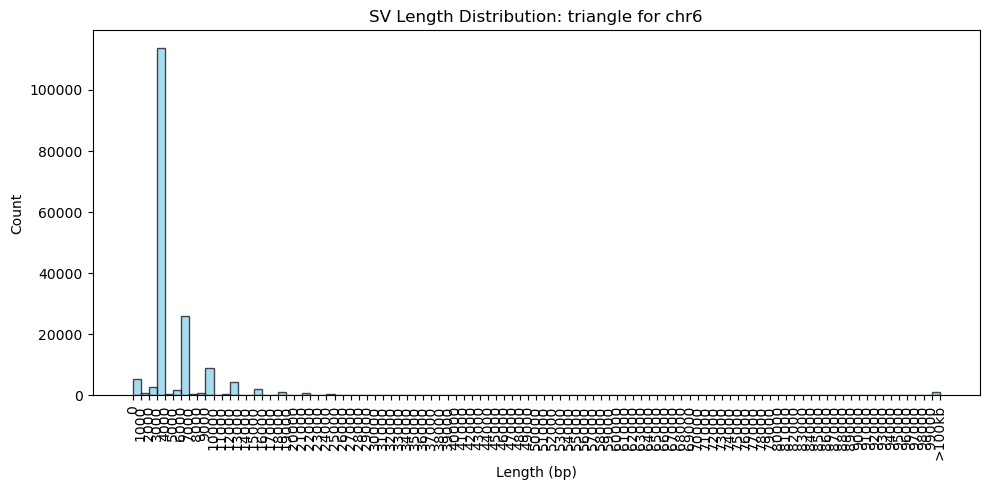

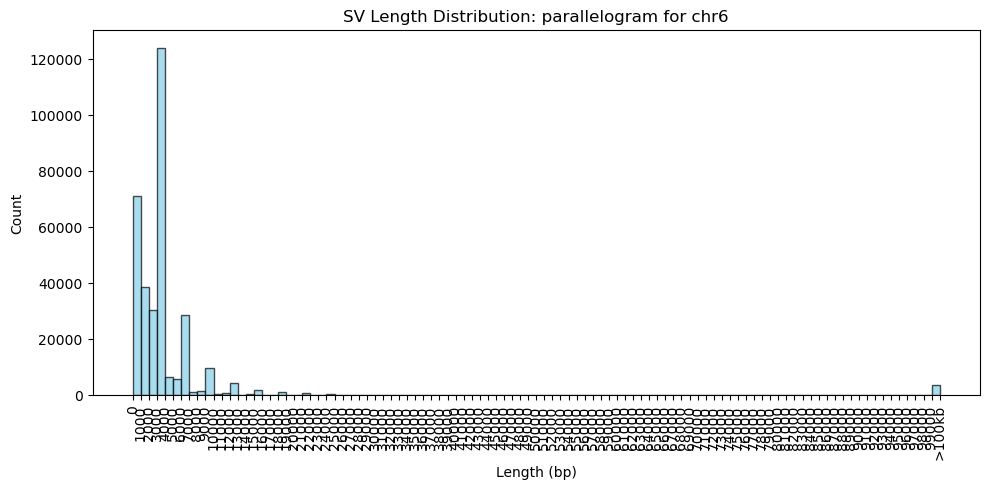

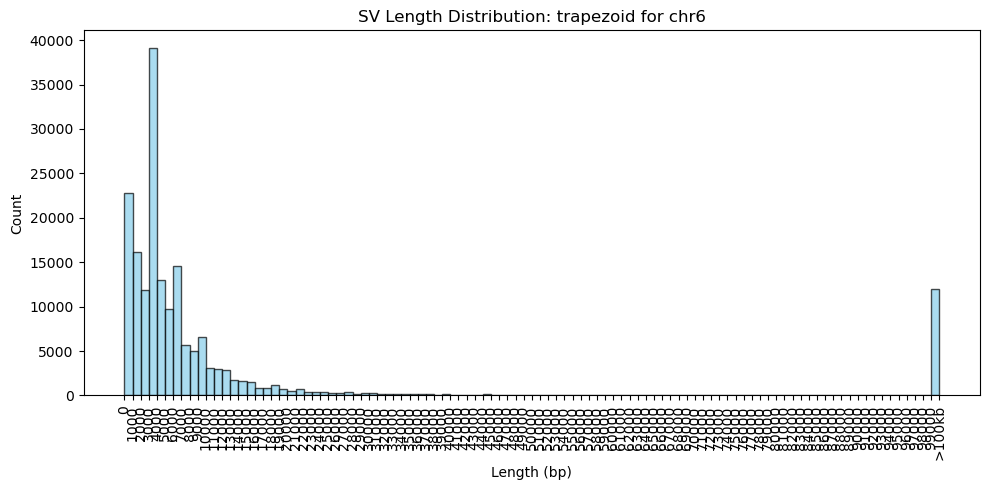

Plotted length distribution for chromosome chr6


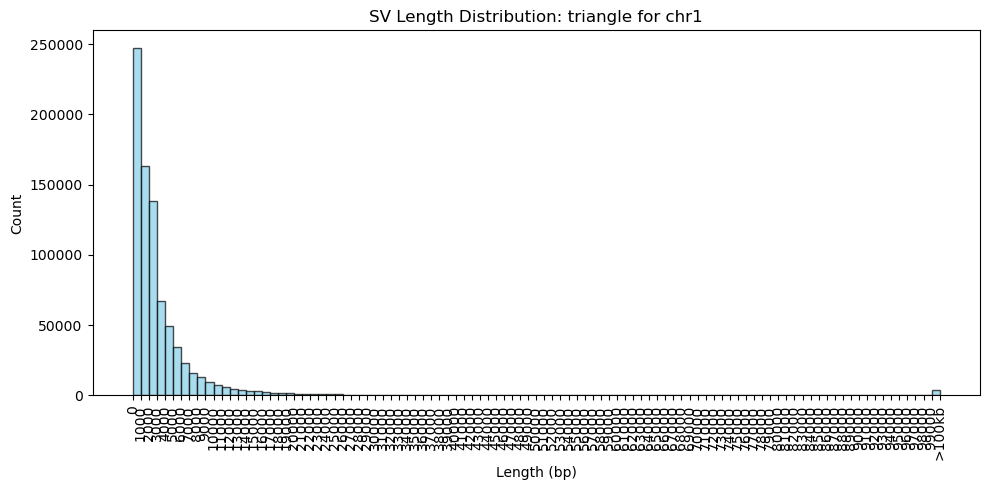

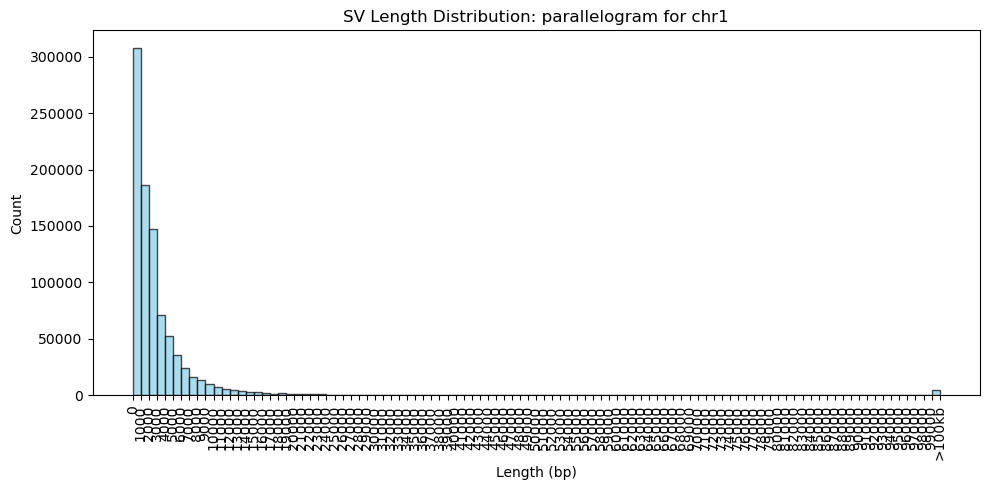

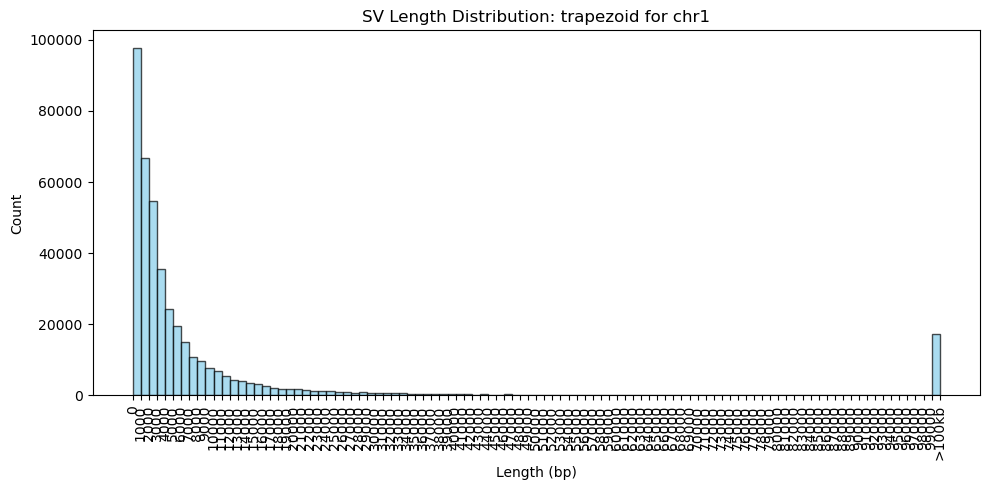

Plotted length distribution for chromosome chr1


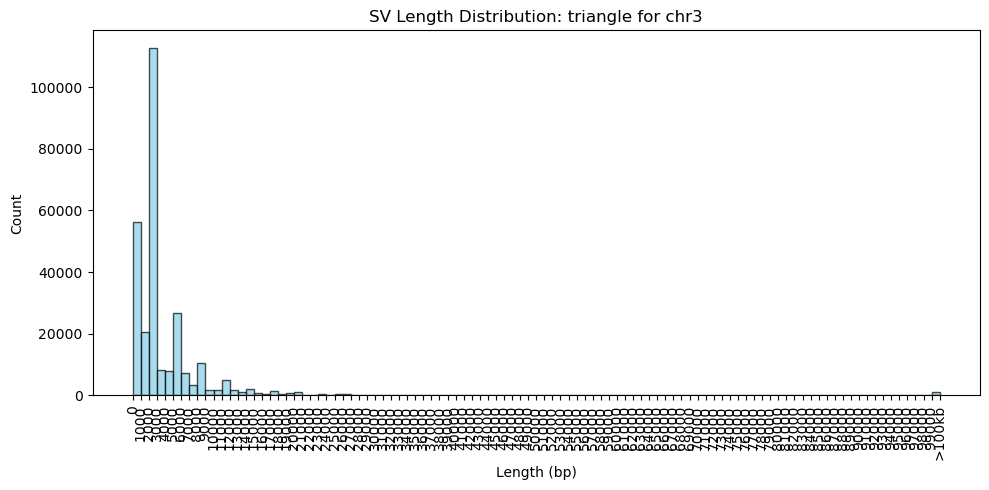

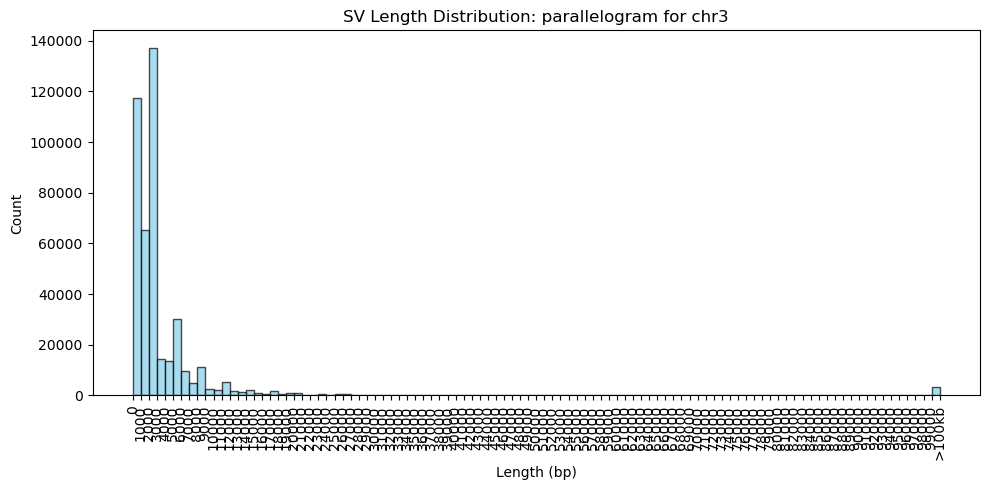

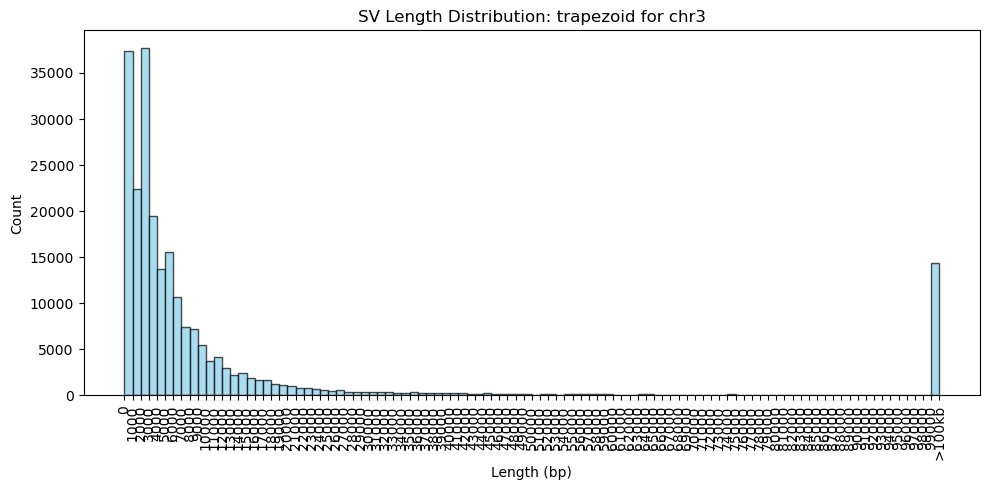

Plotted length distribution for chromosome chr3


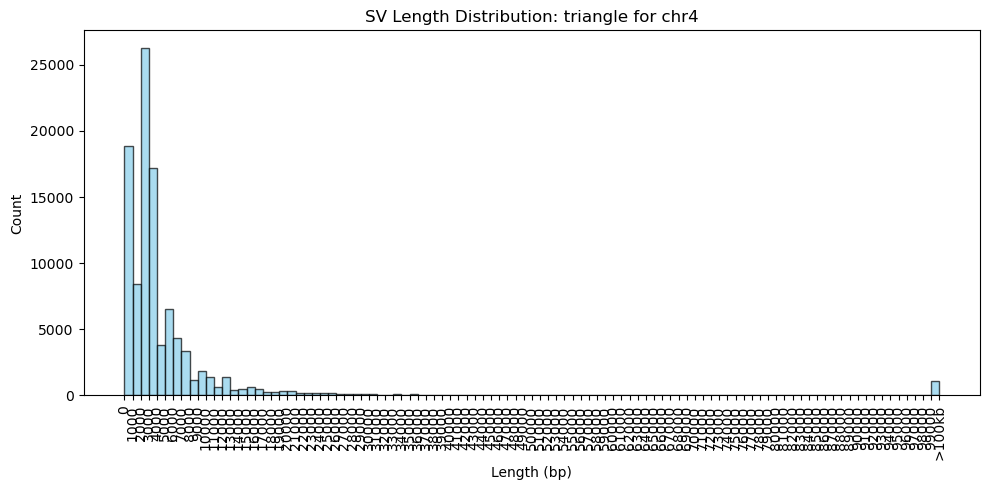

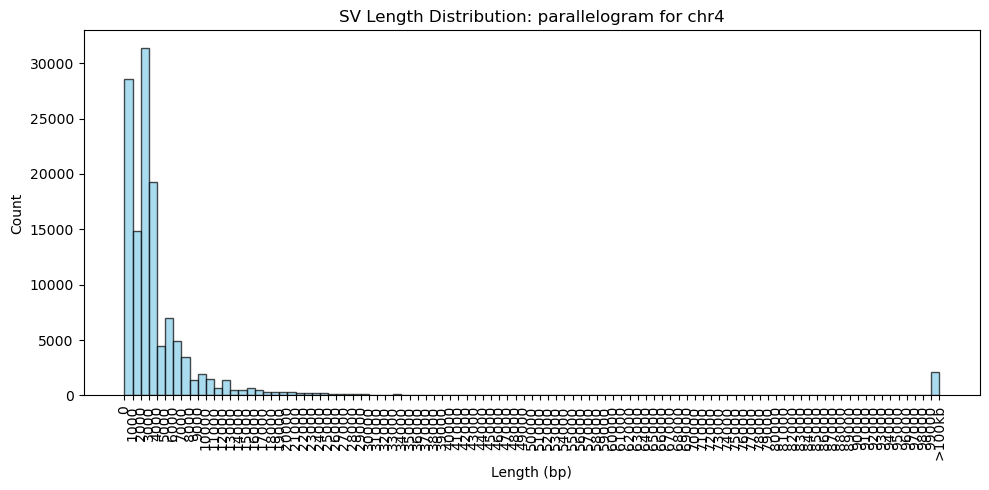

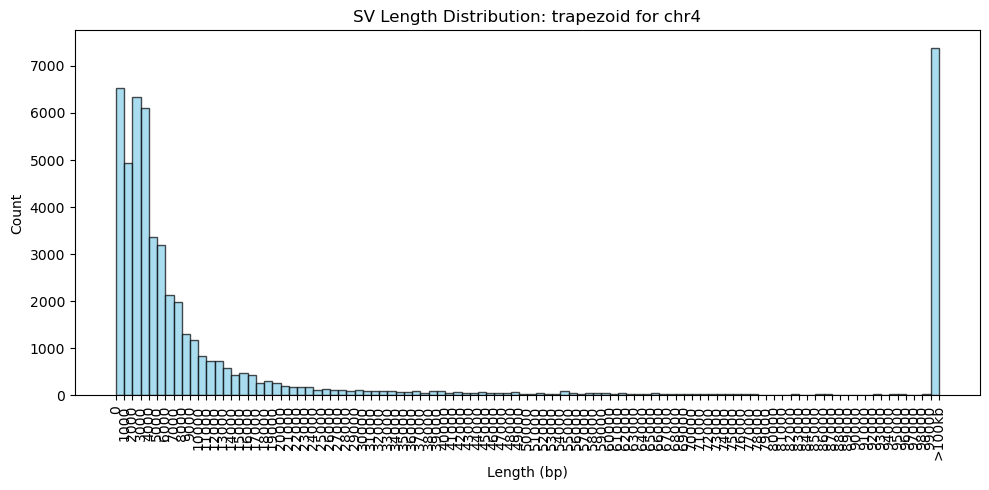

Plotted length distribution for chromosome chr4


In [27]:
plot_prefix = "my_plots_"  # change as needed

for chrom in ["chr6", "chr1","chr3","chr4"]:
    # subset to this chromosome
    chrom_df = df_subset[df_subset['chr'] == chrom].copy()
    
    # build plot filename
    plot_file = f"{plot_prefix}SVs_1150_2kb_chr{chrom}"
    
    # call the plotting function
    plot_length_distributions(
        chrom_df,
        plot_file,
        chrom,
        bin_size=1000,
        max_bin=100000
    )
    
    print(f"Plotted length distribution for chromosome {chrom}")